### INPUTS

In [71]:
cbat_valor       = 3.355
Nbat_valor       = 6
P_BESS           = 5.1                        ##### P_BESS = Nbat_valor * cbat_valor / 4
MWh_STS          = cbat_valor * Nbat_valor
Do               = 0.965
MWp_perfil       = 10.2
fp               = 0.3
eta_poi          = 0.985
CAPEX_MW_PV      = 470_000                  ### FIX 
OPEX_MW_PV       = 8_000                    ### FIX
# CAPEX_MW_PV      = 530_000                    ### Tracker
# OPEX_MW_PV       = 12_000                     ### Tracker
CAPEX_MWh_BESS   = 140_000
OPEX_MWh_BESS    = 2_000
r                = 0.08

AÑO_CERO_VAN = 2025



# Selección y descuento de barras

In [2]:
import pandas as pd
import numpy as np
import holidays 
from typing import Optional

def expandir_escenarios_cmg(excel_path: str, sheet_name: str, start_date_str: str, end_date_str: str) -> Optional[pd.DataFrame]:
    """
    Expande los escenarios de precios de CMg representativos (mensual/horario)
    a una serie de tiempo horaria completa, leyendo los datos Hábiles y No Hábiles
    y aplica un factor de descuento anual del 8%.
    """
    
    print(f"--- Iniciando procesamiento para: {sheet_name} ---")

    N_SCENARIOS = 136
    TASA_DESCUENTO = r
    N_COLS_EXPECTED = N_SCENARIOS + 2 # Date, Hour, 136 Escenarios = 138

    # --- 1. Cargar y Procesar Datos Representativos (Hábiles y No Hábiles) ---
    print(f"Paso 1a: Cargando datos Hábiles desde '{excel_path}'...")
    try:
        # Rango "B:EI" (Asumido en tu último intento, contiene las 138 columnas necesarias)
        df_habil = pd.read_excel(excel_path, sheet_name=sheet_name, header=2, 
                                 usecols="B:EI", engine='openpyxl')
        
        # Asegurarse de tomar solo las primeras 138 columnas y asignar nombres
        if df_habil.shape[1] < N_COLS_EXPECTED:
             print(f"ERROR: La sección Habil tiene solo {df_habil.shape[1]} columnas, se esperaban {N_COLS_EXPECTED}. Revise el rango usecols='B:EI'.")
             return None
             
        df_habil = df_habil.iloc[:, :N_COLS_EXPECTED] 
        df_habil.columns = ['Date', 'Hour'] + [f'Esc_{i+1}_H' for i in range(N_SCENARIOS)]
        
    except Exception as e:
        print(f"ERROR al cargar datos Hábiles: {e}")
        return None
        
    print("Paso 1b: Cargando datos No Hábiles...")
    try:
        # Rango "EL:JS" (Asumido en tu último intento)
        df_no_habil = pd.read_excel(excel_path, sheet_name=sheet_name, header=2, 
                                    usecols="EL:JS", engine='openpyxl') 
        
        # Asegurarse de tomar solo las primeras 138 columnas y asignar nombres
        if df_no_habil.shape[1] < N_COLS_EXPECTED:
             print(f"ERROR: La sección No Habil tiene solo {df_no_habil.shape[1]} columnas, se esperaban {N_COLS_EXPECTED}. Revise el rango usecols='EL:JS'.")
             return None
             
        df_no_habil = df_no_habil.iloc[:, :N_COLS_EXPECTED] 
        df_no_habil.columns = ['Date_NH', 'Hour_NH'] + [f'Esc_{i+1}_NH' for i in range(N_SCENARIOS)]
        
    except Exception as e:
        print(f"ERROR al cargar datos No Hábiles: {e}")
        return None
        
    # Concatenar para tener el DataFrame representativo completo
    df_rep = pd.concat([df_habil, df_no_habil.drop(columns=['Date_NH', 'Hour_NH'])], axis=1)

    # Limpieza de filas vacías
    df_rep = df_rep.dropna(subset=['Date', 'Hour'])
    
    # --- 2. CONVERSIONES CRÍTICAS y PREPARACIÓN DE FECHAS ---
    
    print("Paso 2: Conversiones y preparación de fechas...")
    # 2a. Convertir 'Date' a formato datetime
    try:
        df_rep['Date'] = pd.to_datetime(df_rep['Date'], dayfirst=True, errors='coerce')
        df_rep = df_rep.dropna(subset=['Date'])
    except Exception as e:
        print(f"ERROR: No se pudo convertir la columna 'Date' a fecha. Error: {e}")
        return None
        
    # 2b. Asegurar que 'Hour' sea un entero
    try:
        df_rep['Hour'] = pd.to_numeric(df_rep['Hour'], errors='coerce')
        df_rep = df_rep.dropna(subset=['Hour'])
        df_rep['Hour'] = df_rep['Hour'].astype(int)
    except Exception as e:
        print(f"ERROR: No se pudo convertir la columna 'Hour' a entero. Error: {e}")
        return None
    
    # Extraer Año, Mes, y Hora Ajustada
    df_rep['Year'] = df_rep['Date'].dt.year
    df_rep['Month'] = df_rep['Date'].dt.month
    df_rep['Hour_Adj'] = df_rep['Hour'] - 1 # 1-24 a 0-23
    
    # --- 3. Forzar Tipos a Float en Escenarios ---
    print("Paso 3: Forzando tipos numéricos en escenarios...")
    
    all_esc_cols = [f'Esc_{i+1}_H' for i in range(N_SCENARIOS)] + [f'Esc_{i+1}_NH' for i in range(N_SCENARIOS)]
    
    for col in all_esc_cols:
        df_rep[col] = pd.to_numeric(df_rep[col], errors='coerce')
    
    df_rep_clean = df_rep.dropna(subset=all_esc_cols) # Eliminar filas donde los precios sean NaN

    cols_to_keep = ['Year', 'Month', 'Hour_Adj'] + all_esc_cols
    df_rep_clean = df_rep_clean[cols_to_keep]

    # --- 4. Crear Serie de Tiempo Completa (Backbone) y calcular Factor de Descuento ---
    print("Paso 4: Creando serie de tiempo horaria completa...")
    
    end_date_dt = pd.to_datetime(end_date_str) + pd.Timedelta(days=1) - pd.Timedelta(hours=1)
    
    hourly_index = pd.date_range(start=start_date_str, end=end_date_dt, freq='h') 
    df_full = pd.DataFrame(hourly_index, columns=['fecha_hora'])
    
    # Preparar columnas para el merge y el descuento
    df_full['Year'] = df_full['fecha_hora'].dt.year
    df_full['Month'] = df_full['fecha_hora'].dt.month
    df_full['Hour_Adj'] = df_full['fecha_hora'].dt.hour
    df_full['weekday'] = df_full['fecha_hora'].dt.weekday
    df_full['date_only'] = df_full['fecha_hora'].dt.date
    
    # Calcular el factor de descuento para cada registro
    # BASE_YEAR = pd.to_datetime(start_date_str).year

    df_full['Discount_Factor'] = (1 + TASA_DESCUENTO) ** (-(df_full['Year'] - AÑO_CERO_VAN))
    print(f"    > Aplicando descuento anual del {TASA_DESCUENTO*100}% basado en el año {AÑO_CERO_VAN}.")
    
    # --- 5. Identificar Días Hábiles vs. No Hábiles (Incluyendo Feriados) ---
    print("Paso 5: Aplicando lógica de días hábiles (L-V) y feriados...")
    
    start_year = pd.to_datetime(start_date_str).year
    end_year = pd.to_datetime(end_date_str).year
    
    # Feriados de Chile (ajusta si necesitas otro país)
    cl_holidays = holidays.Chile(years=range(start_year, end_year + 1))
    
    is_weekday_mask = (df_full['weekday'] < 5) # Lunes(0) a Viernes(4)
    is_holiday_mask = df_full['date_only'].isin(cl_holidays)
    
    df_full['is_habil'] = is_weekday_mask & (~is_holiday_mask)
    
    # --- 6. Merge, Descuento y Selección Final de Escenarios (Optimizado) ---
    print("Paso 6: Fusionando datos, aplicando descuento y seleccionando escenarios...")
    
    df_merged = pd.merge(
        df_full,
        df_rep_clean,
        on=['Year', 'Month', 'Hour_Adj'],
        how='left'
    )
    
    if df_merged.isnull().values.any():
        null_rows = df_merged[df_merged.isnull().any(axis=1)]
        print(f"ADVERTENCIA: Se encontraron {len(null_rows)} filas con nulos después del merge.")
    
    # Preparamos una lista para almacenar las nuevas columnas de escenarios
    escenario_columns = []
    is_habil_mask_np = df_merged['is_habil'].to_numpy()
    discount_factor_np = df_merged['Discount_Factor'].to_numpy()
    
    # 1. Creamos las series de escenarios fuera del DataFrame final
    for i in range(1, N_SCENARIOS + 1):
        col_name = f'Escenario_{i}'
        col_habil = f'Esc_{i}_H'
        col_no_habil = f'Esc_{i}_NH'
        
        # Paso A: Seleccionar el precio (Hábil o No Hábil)
        selected_price = np.where(
            is_habil_mask_np,
            df_merged[col_habil].fillna(0).astype(float),
            df_merged[col_no_habil].fillna(0).astype(float)
        )
        
        # Paso B: Aplicar el factor de descuento (Paso Crítico)
        discounted_price = selected_price * discount_factor_np
        
        # Almacenamos la nueva columna como una Serie de Pandas con su nombre
        escenario_columns.append(pd.Series(discounted_price, name=col_name, index=df_merged.index))
    
    # 2. Concatenamos todas las nuevas columnas a la vez
    df_final_escenarios = pd.concat([df_merged['fecha_hora']] + escenario_columns, axis=1)

    print(f"--- Procesamiento completado para: {sheet_name} ---")
    return df_final_escenarios

# ----------------------------------------------------------------------
#                         SCRIPT PRINCIPAL
# ----------------------------------------------------------------------
if __name__ == '__main__':
    ARCHIVO_EXCEL = "CMg_Val.xlsx"
    FECHA_INICIO = "2029-04-01"
    FECHA_FIN = "2048-12-31" 

    print("=========================================================")
    print("       INICIO DE PROCESAMIENTO DE ESCENARIOS CMg         ")
    print("=========================================================")

    # --- 1. Procesar la primera hoja: Lagunas 220 kV ---
    df_lagunas = expandir_escenarios_cmg(
        excel_path=ARCHIVO_EXCEL,
        sheet_name="Lagunas 220 kV",
        start_date_str=FECHA_INICIO,
        end_date_str=FECHA_FIN
    )
    
    # --- 2. Procesar la segunda hoja: Alto Jahuel 220 kV ---
    print("\n" + "="*50 + "\n")
    df_alto_jahuel = expandir_escenarios_cmg(
        excel_path=ARCHIVO_EXCEL,
        sheet_name="Alto Jahuel 220 kV",
        start_date_str=FECHA_INICIO,
        end_date_str=FECHA_FIN
    )
    
    # --- 3. Unir y Renombrar DataFrames (MODIFICACIÓN CLAVE) ---
    
    if df_lagunas is not None and df_alto_jahuel is not None:
        print("\n" + "="*50 + "\n")
        print("Paso 7: Uniendo y renombrando DataFrames...")
        
        # --- FUNCIÓN DE RENOMBRADO MODIFICADA ---
        def rename_cmg_cols(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
            renamed_cols = {}
            for col in df.columns:
                if col.startswith('Escenario_'):
                    # Extraer el número del escenario (ej: 1, 16, 136)
                    scenario_num = col.split('_')[1]
                    # Rellenar con ceros a la izquierda hasta 4 dígitos (ej: 16 -> 0016)
                    formatted_num = scenario_num.zfill(4)
                    
                    # Formato final: [Prefijo]&Serie [Número Formateado]
                    new_col_name = f"{prefix}&Serie {formatted_num}"
                    renamed_cols[col] = new_col_name
            return df.rename(columns=renamed_cols)

        # Aplicar el nuevo renombrado a Lagunas
        df_lagunas_renamed = rename_cmg_cols(df_lagunas, "Lagunas220")
        
        # Aplicar el nuevo renombrado a Alto Jahuel
        df_alto_jahuel_renamed = rename_cmg_cols(df_alto_jahuel, "AltoJahuel220")
        
        # Unir ambos DataFrames por la columna 'fecha_hora'
        df_final = pd.merge(
            df_lagunas_renamed, 
            df_alto_jahuel_renamed, 
            on='fecha_hora', 
            how='inner' # Se usa inner merge para asegurar que solo queden las horas comunes
        )
        
        print("\n✅ --- Resultado Final Unificado (Primeras 5 filas) ---")
        print(df_final.head())
        print("\nEjemplo de columnas renombradas:")
        print(f"Lagunas: {df_final.columns[1]} (Ejemplo: Lagunas220&Serie 0001)")
        print(f"Lagunas: {df_final.columns[16]} (Ejemplo: Lagunas220&Serie 0016)")
        print(f"Alto Jahuel: {df_final.columns[138]} (Ejemplo: AltoJahuel220&Serie 0002)")
        
        print(f"\nNúmero de filas totales: {len(df_final)}")
        print("\nResumen de tipos de datos:")
        df_final.info()
        df_final.to_excel("precios_descontados_final.xlsx",index=False)

    else:
        print("\n❌ No se pudo realizar la unión porque uno o ambos DataFrames no se generaron correctamente.")

       INICIO DE PROCESAMIENTO DE ESCENARIOS CMg         
--- Iniciando procesamiento para: Lagunas 220 kV ---
Paso 1a: Cargando datos Hábiles desde 'CMg_Val.xlsx'...
Paso 1b: Cargando datos No Hábiles...
Paso 2: Conversiones y preparación de fechas...
Paso 3: Forzando tipos numéricos en escenarios...
Paso 4: Creando serie de tiempo horaria completa...
    > Aplicando descuento anual del 8.0% basado en el año 2025.
Paso 5: Aplicando lógica de días hábiles (L-V) y feriados...
Paso 6: Fusionando datos, aplicando descuento y seleccionando escenarios...
--- Procesamiento completado para: Lagunas 220 kV ---


--- Iniciando procesamiento para: Alto Jahuel 220 kV ---
Paso 1a: Cargando datos Hábiles desde 'CMg_Val.xlsx'...
Paso 1b: Cargando datos No Hábiles...
Paso 2: Conversiones y preparación de fechas...
Paso 3: Forzando tipos numéricos en escenarios...
Paso 4: Creando serie de tiempo horaria completa...
    > Aplicando descuento anual del 8.0% basado en el año 2025.
Paso 5: Aplicando lógic

### + 7 series planas

In [3]:
# import pandas as pd
# import numpy as np
# import holidays 
# from typing import Optional

# def expandir_escenarios_cmg(excel_path: str, sheet_name: str, start_date_str: str, end_date_str: str) -> Optional[pd.DataFrame]:
#     """
#     Expande los escenarios de precios de CMg representativos (mensual/horario)
#     a una serie de tiempo horaria completa, leyendo los datos Hábiles y No Hábiles
#     y aplica un factor de descuento anual del 8%.
#     """
    
#     print(f"--- Iniciando procesamiento para: {sheet_name} ---")

#     N_SCENARIOS = 143
#     TASA_DESCUENTO = r
#     N_COLS_EXPECTED = N_SCENARIOS + 2 # Date, Hour, 136 Escenarios = 138

#     # --- 1. Cargar y Procesar Datos Representativos (Hábiles y No Hábiles) ---
#     print(f"Paso 1a: Cargando datos Hábiles desde '{excel_path}'...")
#     try:
#         # Rango "B:EI" (Asumido en tu último intento, contiene las 138 columnas necesarias)
#         df_habil = pd.read_excel(excel_path, sheet_name=sheet_name, header=2, 
#                                  usecols="B:EP", engine='openpyxl')
        
#         # Asegurarse de tomar solo las primeras 138 columnas y asignar nombres
#         if df_habil.shape[1] < N_COLS_EXPECTED:
#              print(f"ERROR: La sección Habil tiene solo {df_habil.shape[1]} columnas, se esperaban {N_COLS_EXPECTED}. Revise el rango usecols='B:EI'.")
#              return None
             
#         df_habil = df_habil.iloc[:, :N_COLS_EXPECTED] 
#         df_habil.columns = ['Date', 'Hour'] + [f'Esc_{i+1}_H' for i in range(N_SCENARIOS)]
        
#     except Exception as e:
#         print(f"ERROR al cargar datos Hábiles: {e}")
#         return None
        
#     print("Paso 1b: Cargando datos No Hábiles...")
#     try:
#         # Rango "EL:JS" (Asumido en tu último intento)
#         df_no_habil = pd.read_excel(excel_path, sheet_name=sheet_name, header=2, 
#                                     usecols="ES:KG", engine='openpyxl') 
        
#         # Asegurarse de tomar solo las primeras 138 columnas y asignar nombres
#         if df_no_habil.shape[1] < N_COLS_EXPECTED:
#              print(f"ERROR: La sección No Habil tiene solo {df_no_habil.shape[1]} columnas, se esperaban {N_COLS_EXPECTED}. Revise el rango usecols='EL:JS'.")
#              return None
             
#         df_no_habil = df_no_habil.iloc[:, :N_COLS_EXPECTED] 
#         df_no_habil.columns = ['Date_NH', 'Hour_NH'] + [f'Esc_{i+1}_NH' for i in range(N_SCENARIOS)]
        
#     except Exception as e:
#         print(f"ERROR al cargar datos No Hábiles: {e}")
#         return None
        
#     # Concatenar para tener el DataFrame representativo completo
#     df_rep = pd.concat([df_habil, df_no_habil.drop(columns=['Date_NH', 'Hour_NH'])], axis=1)

#     # Limpieza de filas vacías
#     df_rep = df_rep.dropna(subset=['Date', 'Hour'])
    
#     # --- 2. CONVERSIONES CRÍTICAS y PREPARACIÓN DE FECHAS ---
    
#     print("Paso 2: Conversiones y preparación de fechas...")
#     # 2a. Convertir 'Date' a formato datetime
#     try:
#         df_rep['Date'] = pd.to_datetime(df_rep['Date'], dayfirst=True, errors='coerce')
#         df_rep = df_rep.dropna(subset=['Date'])
#     except Exception as e:
#         print(f"ERROR: No se pudo convertir la columna 'Date' a fecha. Error: {e}")
#         return None
        
#     # 2b. Asegurar que 'Hour' sea un entero
#     try:
#         df_rep['Hour'] = pd.to_numeric(df_rep['Hour'], errors='coerce')
#         df_rep = df_rep.dropna(subset=['Hour'])
#         df_rep['Hour'] = df_rep['Hour'].astype(int)
#     except Exception as e:
#         print(f"ERROR: No se pudo convertir la columna 'Hour' a entero. Error: {e}")
#         return None
    
#     # Extraer Año, Mes, y Hora Ajustada
#     df_rep['Year'] = df_rep['Date'].dt.year
#     df_rep['Month'] = df_rep['Date'].dt.month
#     df_rep['Hour_Adj'] = df_rep['Hour'] - 1 # 1-24 a 0-23
    
#     # --- 3. Forzar Tipos a Float en Escenarios ---
#     print("Paso 3: Forzando tipos numéricos en escenarios...")
    
#     all_esc_cols = [f'Esc_{i+1}_H' for i in range(N_SCENARIOS)] + [f'Esc_{i+1}_NH' for i in range(N_SCENARIOS)]
    
#     for col in all_esc_cols:
#         df_rep[col] = pd.to_numeric(df_rep[col], errors='coerce')
    
#     df_rep_clean = df_rep.dropna(subset=all_esc_cols) # Eliminar filas donde los precios sean NaN

#     cols_to_keep = ['Year', 'Month', 'Hour_Adj'] + all_esc_cols
#     df_rep_clean = df_rep_clean[cols_to_keep]

#     # --- 4. Crear Serie de Tiempo Completa (Backbone) y calcular Factor de Descuento ---
#     print("Paso 4: Creando serie de tiempo horaria completa...")
    
#     end_date_dt = pd.to_datetime(end_date_str) + pd.Timedelta(days=1) - pd.Timedelta(hours=1)
    
#     hourly_index = pd.date_range(start=start_date_str, end=end_date_dt, freq='h') 
#     df_full = pd.DataFrame(hourly_index, columns=['fecha_hora'])
    
#     # Preparar columnas para el merge y el descuento
#     df_full['Year'] = df_full['fecha_hora'].dt.year
#     df_full['Month'] = df_full['fecha_hora'].dt.month
#     df_full['Hour_Adj'] = df_full['fecha_hora'].dt.hour
#     df_full['weekday'] = df_full['fecha_hora'].dt.weekday
#     df_full['date_only'] = df_full['fecha_hora'].dt.date
    
#     # Calcular el factor de descuento para cada registro
#     # BASE_YEAR = pd.to_datetime(start_date_str).year

#     df_full['Discount_Factor'] = (1 + TASA_DESCUENTO) ** (-(df_full['Year'] - AÑO_CERO_VAN))
#     print(f"    > Aplicando descuento anual del {TASA_DESCUENTO*100}% basado en el año {AÑO_CERO_VAN}.")
    
#     # --- 5. Identificar Días Hábiles vs. No Hábiles (Incluyendo Feriados) ---
#     print("Paso 5: Aplicando lógica de días hábiles (L-V) y feriados...")
    
#     start_year = pd.to_datetime(start_date_str).year
#     end_year = pd.to_datetime(end_date_str).year
    
#     # Feriados de Chile (ajusta si necesitas otro país)
#     cl_holidays = holidays.Chile(years=range(start_year, end_year + 1))
    
#     is_weekday_mask = (df_full['weekday'] < 5) # Lunes(0) a Viernes(4)
#     is_holiday_mask = df_full['date_only'].isin(cl_holidays)
    
#     df_full['is_habil'] = is_weekday_mask & (~is_holiday_mask)
    
#     # --- 6. Merge, Descuento y Selección Final de Escenarios (Optimizado) ---
#     print("Paso 6: Fusionando datos, aplicando descuento y seleccionando escenarios...")
    
#     df_merged = pd.merge(
#         df_full,
#         df_rep_clean,
#         on=['Year', 'Month', 'Hour_Adj'],
#         how='left'
#     )
    
#     if df_merged.isnull().values.any():
#         null_rows = df_merged[df_merged.isnull().any(axis=1)]
#         print(f"ADVERTENCIA: Se encontraron {len(null_rows)} filas con nulos después del merge.")
    
#     # Preparamos una lista para almacenar las nuevas columnas de escenarios
#     escenario_columns = []
#     is_habil_mask_np = df_merged['is_habil'].to_numpy()
#     discount_factor_np = df_merged['Discount_Factor'].to_numpy()
    
#     # 1. Creamos las series de escenarios fuera del DataFrame final
#     for i in range(1, N_SCENARIOS + 1):
#         col_name = f'Escenario_{i}'
#         col_habil = f'Esc_{i}_H'
#         col_no_habil = f'Esc_{i}_NH'
        
#         # Paso A: Seleccionar el precio (Hábil o No Hábil)
#         selected_price = np.where(
#             is_habil_mask_np,
#             df_merged[col_habil].fillna(0).astype(float),
#             df_merged[col_no_habil].fillna(0).astype(float)
#         )
        
#         # Paso B: Aplicar el factor de descuento (Paso Crítico)
#         discounted_price = selected_price * discount_factor_np
        
#         # Almacenamos la nueva columna como una Serie de Pandas con su nombre
#         escenario_columns.append(pd.Series(discounted_price, name=col_name, index=df_merged.index))
    
#     # 2. Concatenamos todas las nuevas columnas a la vez
#     df_final_escenarios = pd.concat([df_merged['fecha_hora']] + escenario_columns, axis=1)

#     print(f"--- Procesamiento completado para: {sheet_name} ---")
#     return df_final_escenarios

# # ----------------------------------------------------------------------
# #                         SCRIPT PRINCIPAL
# # ----------------------------------------------------------------------
# if __name__ == '__main__':
#     ARCHIVO_EXCEL = "CMg_Val_40.xlsx"
#     FECHA_INICIO = "2029-04-01"
#     FECHA_FIN = "2048-12-31" 

#     print("=========================================================")
#     print("       INICIO DE PROCESAMIENTO DE ESCENARIOS CMg         ")
#     print("=========================================================")

#     # --- 1. Procesar la primera hoja: Lagunas 220 kV ---
#     df_lagunas = expandir_escenarios_cmg(
#         excel_path=ARCHIVO_EXCEL,
#         sheet_name="Lagunas 220 kV",
#         start_date_str=FECHA_INICIO,
#         end_date_str=FECHA_FIN
#     )
    
#     # --- 2. Procesar la segunda hoja: Alto Jahuel 220 kV ---
#     print("\n" + "="*50 + "\n")
#     df_alto_jahuel = expandir_escenarios_cmg(
#         excel_path=ARCHIVO_EXCEL,
#         sheet_name="Alto Jahuel 220 kV",
#         start_date_str=FECHA_INICIO,
#         end_date_str=FECHA_FIN
#     )
    
#     # --- 3. Unir y Renombrar DataFrames (MODIFICACIÓN CLAVE) ---
    
#     if df_lagunas is not None and df_alto_jahuel is not None:
#         print("\n" + "="*50 + "\n")
#         print("Paso 7: Uniendo y renombrando DataFrames...")
        
#         # --- FUNCIÓN DE RENOMBRADO MODIFICADA ---
#         def rename_cmg_cols(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
#             renamed_cols = {}
#             for col in df.columns:
#                 if col.startswith('Escenario_'):
#                     # Extraer el número del escenario (ej: 1, 16, 136)
#                     scenario_num = col.split('_')[1]
#                     # Rellenar con ceros a la izquierda hasta 4 dígitos (ej: 16 -> 0016)
#                     formatted_num = scenario_num.zfill(4)
                    
#                     # Formato final: [Prefijo]&Serie [Número Formateado]
#                     new_col_name = f"{prefix}&Serie {formatted_num}"
#                     renamed_cols[col] = new_col_name
#             return df.rename(columns=renamed_cols)

#         # Aplicar el nuevo renombrado a Lagunas
#         df_lagunas_renamed = rename_cmg_cols(df_lagunas, "Lagunas220")
        
#         # Aplicar el nuevo renombrado a Alto Jahuel
#         df_alto_jahuel_renamed = rename_cmg_cols(df_alto_jahuel, "AltoJahuel220")
        
#         # Unir ambos DataFrames por la columna 'fecha_hora'
#         df_final = pd.merge(
#             df_lagunas_renamed, 
#             df_alto_jahuel_renamed, 
#             on='fecha_hora', 
#             how='inner' # Se usa inner merge para asegurar que solo queden las horas comunes
#         )
        
#         print("\n✅ --- Resultado Final Unificado (Primeras 5 filas) ---")
#         print(df_final.head())
#         print("\nEjemplo de columnas renombradas:")
#         print(f"Lagunas: {df_final.columns[1]} (Ejemplo: Lagunas220&Serie 0001)")
#         print(f"Lagunas: {df_final.columns[16]} (Ejemplo: Lagunas220&Serie 0016)")
#         print(f"Alto Jahuel: {df_final.columns[138]} (Ejemplo: AltoJahuel220&Serie 0002)")
        
#         print(f"\nNúmero de filas totales: {len(df_final)}")
#         print("\nResumen de tipos de datos:")
#         df_final.info()
#         df_final.to_excel("precios_descontados_final.xlsx",index=False)

#     else:
#         print("\n❌ No se pudo realizar la unión porque uno o ambos DataFrames no se generaron correctamente.")

# Expansión y Degradación PV

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import math # Se necesita para math.ceil en el cálculo de años

def expandir_perfil_pv_degradacion(archivo_perfil_pv: str, start_date_str: str, end_date_str: str, tasa_degradacion: float = 0.004) -> pd.DataFrame:
    """
    Expande un perfil fotovoltaico horario de 1 año al rango de fechas especificado,
    aplicando degradación anual compuesta.
    
    Parámetros:
    -----------
    archivo_perfil_pv : str
        Ruta al archivo Excel con columnas: 'Fecha' y 'Generacion PV'
    start_date_str : str
        Fecha de inicio del periodo de expansión (e.g., "2029-04-01").
    end_date_str : str
        Fecha de fin del periodo de expansión (e.g., "2048-12-31").
    tasa_degradacion : float
        Tasa de degradación anual (default: 0.004 = 0.4%)
        
    Retorna:
    --------
    pandas.DataFrame
        DataFrame con datos horarios con degradación aplicada, filtrado por el rango [FECHA_INICIO, FECHA_FIN].
    """
    
    # Convertir las fechas de entrada
    fecha_inicio_dt = pd.to_datetime(start_date_str).normalize() # Normalizar a medianoche
    fecha_fin_dt = pd.to_datetime(end_date_str).normalize() + pd.Timedelta(hours=23) # Asegurar hasta el final del día

    if fecha_inicio_dt > fecha_fin_dt:
        raise ValueError("La FECHA_INICIO debe ser anterior o igual a la FECHA_FIN.")
    
    # Determinar el rango de años para el bucle de expansión
    ANIO_INICIO = fecha_inicio_dt.year
    ANIO_FIN = fecha_fin_dt.year
    
    # Calculamos la cantidad de años a generar (usamos +1 para incluir el año final)
    NUM_ANIOS_GENERAR = ANIO_FIN - ANIO_INICIO + 1 

    print(f"--- 🚀 INICIANDO EXPANSIÓN PV ---")
    print(f"Período solicitado: {start_date_str} a {end_date_str}")
    print(f"Años a generar (max): {NUM_ANIOS_GENERAR} ({ANIO_INICIO} a {ANIO_FIN})")
    print(f"Tasa de degradación: {tasa_degradacion*100:.2f}%")
    
    # ==================================================================
    # 1. LECTURA DEL PERFIL BASE (1 AÑO)
    # ==================================================================
    print(f"\n📂 Leyendo perfil fotovoltaico: {archivo_perfil_pv}")
    try:
        df_base = pd.read_excel(archivo_perfil_pv)
        df_base.columns = df_base.columns.str.strip()
        
        # Validar y convertir columnas
        if 'Fecha' not in df_base.columns or 'Generacion PV' not in df_base.columns:
            raise ValueError("El archivo debe contener las columnas 'Fecha' y 'Generacion PV'.")
        
        df_base['Fecha'] = pd.to_datetime(df_base['Fecha'])
        df_base['Generacion PV'] = pd.to_numeric(df_base['Generacion PV'], errors='coerce').fillna(0)
        df_base = df_base.sort_values('Fecha').reset_index(drop=True)
        
    except Exception as e:
        print(f"ERROR al leer/procesar el perfil base: {e}")
        raise
        
    # ==================================================================
    # 2. EXTRAER PATRÓN HORARIO
    # ==================================================================
    # Extraer Mes, Día y Hora para usar como plantilla de repetición
    df_base['Mes'] = df_base['Fecha'].dt.month
    df_base['Dia'] = df_base['Fecha'].dt.day
    df_base['Hora'] = df_base['Fecha'].dt.hour
    
    # Extraer patrón del 28 de febrero para generar el 29 de febrero
    mask_28_feb = (df_base['Mes'] == 2) & (df_base['Dia'] == 28)
    datos_28_feb = df_base[mask_28_feb].copy()
    
    if len(datos_28_feb) != 24:
        print(f"⚠️ Advertencia: El 28 de febrero en el perfil base tiene {len(datos_28_feb)} horas, se usa para template.")
    
    
    # ==================================================================
    # 3. EXPANSIÓN Y DEGRADACIÓN
    # ==================================================================
    print(f"\n📅 Iniciando bucle de expansión de {NUM_ANIOS_GENERAR} años...")
    
    filas_expandidas = []
    
    # Función auxiliar para verificar año bisiesto
    def es_bisiesto(anio):
        return (anio % 4 == 0 and anio % 100 != 0) or (anio % 400 == 0)

    for anio in range(ANIO_INICIO, ANIO_FIN + 1):
        # El índice anio_idx es cuántos años ha transcurrido desde el inicio (0, 1, 2, ...)
        anio_idx = anio - ANIO_INICIO 
        
        es_anio_bisiesto = es_bisiesto(anio)
        
        # Calcular factor de degradación compuesto (exponente: años transcurridos desde el inicio)
        factor_degradacion = (1 - tasa_degradacion) ** anio_idx
        
        # 3.1 Procesar horas estándar (8760/8784)
        for _, row in df_base.iterrows():
            try:
                mes = int(row['Mes'])
                dia = int(row['Dia'])
                hora = int(row['Hora'])
                
                # Crear la fecha para este registro en el año actual
                fecha_actual = datetime(anio, mes, dia, hora, 0, 0)
            except ValueError:
                 # Ignorar si el patrón base contiene 29 de febrero y el año actual no es bisiesto
                 # O si el día/mes no existe en el año (ej: 31 de Febrero)
                 if mes == 2 and dia == 29 and not es_anio_bisiesto:
                     continue
                 # Manejar el caso de que la fecha base sea '2020-02-29' y se repita
                 elif mes == 2 and dia == 29 and es_anio_bisiesto:
                     # Si el patrón base incluye el 29 de Feb, lo ignoramos para procesar solo el 28
                     # La generación del 29 se maneja por separado (usando el 28 como template)
                     continue 
                 else:
                     raise # Lanza error si no es un problema de fecha bisiesta
            
            # Aplicar degradación a la generación
            generacion_degradada = row['Generacion PV'] * factor_degradacion
            
            filas_expandidas.append({
                'Fecha': fecha_actual,
                'Generacion PV': generacion_degradada,
                'Anio': anio,
                'Factor_Degradacion': factor_degradacion
            })
            
        # 3.2 Agregar 29 de febrero si el año es bisiesto
        if es_anio_bisiesto:
            for _, row_28_feb in datos_28_feb.iterrows():
                hora = int(row_28_feb['Hora'])
                fecha_29_feb = datetime(anio, 2, 29, hora, 0, 0)
                generacion_29_feb = row_28_feb['Generacion PV'] * factor_degradacion
                
                filas_expandidas.append({
                    'Fecha': fecha_29_feb,
                    'Generacion PV': generacion_29_feb,
                    'Anio': anio,
                    'Factor_Degradacion': factor_degradacion
                })
        
        print(f"  ✓ Año {anio} (Factor: {factor_degradacion:.6f}) procesado.")
    
    df_expandido = pd.DataFrame(filas_expandidas)
    
    # ==================================================================
    # 4. FILTRADO POR FECHAS DE INICIO Y TÉRMINO
    # ==================================================================
    print(f"\n📋 Filtrando resultado al rango: {fecha_inicio_dt} a {fecha_fin_dt}")
    
    mask_filtro = (df_expandido['Fecha'] >= fecha_inicio_dt) & (df_expandido['Fecha'] <= fecha_fin_dt)
    df_expandido = df_expandido[mask_filtro]
    
    df_expandido = df_expandido.sort_values('Fecha').reset_index(drop=True)
    
    if len(df_expandido) == 0:
        raise ValueError("El rango de fechas no generó ningún registro. Verifique que el rango de años generado es correcto.")
    
    # ==================================================================
    # 5. ESTADÍSTICAS Y PREPARACIÓN DE SALIDA
    # ==================================================================
    
    # Recalcular estadísticas basado en el rango filtrado
    stats_por_anio = df_expandido.groupby('Anio').agg({
        'Generacion PV': ['mean', 'max', 'sum'],
        'Factor_Degradacion': 'first'
    }).round(4)
    stats_por_anio.columns = ['Promedio_MW', 'Maximo_MW', 'Total_MWh', 'Factor_Degradacion']

    # Calcular pérdida acumulada relevante
    primer_anio_filtrado = stats_por_anio.index.min()
    generacion_inicial = stats_por_anio.loc[primer_anio_filtrado, 'Total_MWh']
    generacion_final = stats_por_anio.loc[stats_por_anio.index.max(), 'Total_MWh']
    perdida_acumulada = ((generacion_inicial - generacion_final) / generacion_inicial) * 100
    
    print("\n📊 ANÁLISIS DE DEGRADACIÓN (Período Filtrado):")
    print("="*70)
    print(stats_por_anio.to_string())
    
    print("\n" + "="*70)
    print(f"📉 RESUMEN DE DEGRADACIÓN (Rango {primer_anio_filtrado} a {stats_por_anio.index.max()}):")
    print(f"  - Generación año inicial: {generacion_inicial:,.2f} MWh")
    print(f"  - Generación año final: {generacion_final:,.2f} MWh")
    print(f"  - Pérdida acumulada en el período: {perdida_acumulada:.2f}%")
    print("="*70)
    
    # Seleccionar columnas finales
    df_final = df_expandido[['Fecha', 'Generacion PV']].copy()
    print(f"\n✅ Procesamiento completado: {len(df_final):,} filas generadas.")
    
    return df_final


# ==================================================================
# BLOQUE DE EJECUCIÓN
# ==================================================================
if __name__ == "__main__":
    
    # 📅 Parámetros de entrada de FECHA (Formato requerido)
    FECHA_INICIO = "2029-04-01"
    FECHA_FIN = "2048-12-31" 
    
    # Parámetros técnicos
    # ARCHIVO_PERFIL_PV = "SdL_Fijo.xlsx"  # Ajustar ruta según necesidad
    ARCHIVO_PERFIL_PV = "SdL_Fijo.xlsx"  # Ajustar ruta según necesidad
    TASA_DEGRADACION = 0.004  # 0.4% anual
    ARCHIVO_SALIDA = "perfil_pv_expandido_degradado.xlsx"
    
    try:
        # Ejecutar función de expansión
        print("="*70)
        df_pv_expandido = expandir_perfil_pv_degradacion(
            archivo_perfil_pv=ARCHIVO_PERFIL_PV,
            start_date_str=FECHA_INICIO,
            end_date_str=FECHA_FIN,
            tasa_degradacion=TASA_DEGRADACION
        )
        
        # ... (El bloque de preview y guardado se mantiene)
        # Mostrar preview del resultado
        print("="*70)
        print("📊 PREVIEW DEL RESULTADO:")
        print("="*70)
        print("\nPrimeras 10 filas (debe comenzar en la FECHA_INICIO):")
        print(df_pv_expandido.head(10).to_string())
        print("\nÚltimas 10 filas (debe terminar en la FECHA_FIN):")
        print(df_pv_expandido.tail(10).to_string())
        
        # Estadísticas generales
        print("\n" + "="*70)
        print("📊 ESTADÍSTICAS GENERALES:")
        print("="*70)
        print(f"Total de registros: {len(df_pv_expandido):,}")
        print(f"Rango de fechas: {df_pv_expandido['Fecha'].min()} a {df_pv_expandido['Fecha'].max()}")
        print(f"Generación promedio (período): {df_pv_expandido['Generacion PV'].mean():.2f} MW")
        print(f"Generación total (período): {df_pv_expandido['Generacion PV'].sum():,.2f} MWh")
        
        # Guardar resultado
        print("\n" + "="*70)
        print(f"💾 Guardando resultado en: {ARCHIVO_SALIDA}")
        print("="*70)
        
        df_pv_expandido.to_excel(ARCHIVO_SALIDA, index=False)
        
        print(f"✅ Archivo guardado exitosamente: {ARCHIVO_SALIDA}")
        print("="*70)
        
    except FileNotFoundError:
        print(f"\n❌ ERROR: No se encontró el archivo '{ARCHIVO_PERFIL_PV}'")
    except Exception as e:
        print(f"\n❌ ERROR durante el procesamiento: {type(e).__name__}: {e}")

--- 🚀 INICIANDO EXPANSIÓN PV ---
Período solicitado: 2029-04-01 a 2048-12-31
Años a generar (max): 20 (2029 a 2048)
Tasa de degradación: 0.40%

📂 Leyendo perfil fotovoltaico: SdL_Fijo.xlsx

📅 Iniciando bucle de expansión de 20 años...
  ✓ Año 2029 (Factor: 1.000000) procesado.
  ✓ Año 2030 (Factor: 0.996000) procesado.
  ✓ Año 2031 (Factor: 0.992016) procesado.
  ✓ Año 2032 (Factor: 0.988048) procesado.
  ✓ Año 2033 (Factor: 0.984096) procesado.
  ✓ Año 2034 (Factor: 0.980159) procesado.
  ✓ Año 2035 (Factor: 0.976239) procesado.
  ✓ Año 2036 (Factor: 0.972334) procesado.
  ✓ Año 2037 (Factor: 0.968444) procesado.
  ✓ Año 2038 (Factor: 0.964571) procesado.
  ✓ Año 2039 (Factor: 0.960712) procesado.
  ✓ Año 2040 (Factor: 0.956870) procesado.
  ✓ Año 2041 (Factor: 0.953042) procesado.
  ✓ Año 2042 (Factor: 0.949230) procesado.
  ✓ Año 2043 (Factor: 0.945433) procesado.
  ✓ Año 2044 (Factor: 0.941651) procesado.
  ✓ Año 2045 (Factor: 0.937885) procesado.
  ✓ Año 2046 (Factor: 0.934133) pr

# Perfiles carga y descarga

In [5]:
import pandas as pd
import random

def generar_perfiles_tiempo_dt_final(df_time: pd.DataFrame, seed: int = None) -> pd.DataFrame:
    """
    Dado un DataFrame con un índice de tiempo (datetime), genera perfiles de 
    carga y descarga. Agrega la columna 'Fecha' para replicar el índice.
    """
    
    # 1. Validación y Preparación
    df = df_time.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
         raise ValueError("El DataFrame de entrada debe tener un índice de tipo pd.DatetimeIndex.")

    if seed is not None:
        random.seed(seed)
    
    # === MODIFICACIÓN 1: Añadir la columna 'Fecha' ===
    df['Fecha'] = df.index
    
    # Inicializamos columnas
    df['perfil_carga'] = 0.0
    df['perfil_descarga'] = 0.0

    # 2. Identificar y ordenar todos los días únicos
    days = sorted(df.index.normalize().unique())

    # Ventanas de horas (igual que tu código original)
    ventana_descarga = set(range(18, 24))  # inicios válidos 18..23
    
    # 3. Generación de Perfiles por Día
    for idx_day, start_of_day in enumerate(days):
        
        next_day = days[idx_day + 1] if idx_day + 1 < len(days) else None
        
        # ——— Carga ———
        dur_c = random.randint(4, 8)
        start_c_options = list(range(8, 18 - dur_c + 1)) 
        
        if not start_c_options:
            continue
            
        inicio_c_hour = random.choice(start_c_options)
        inicio_c = start_of_day + pd.Timedelta(hours=inicio_c_hour)
        fin_c_hour = inicio_c_hour + dur_c - 1
        
        # Usamos 'h' en lugar de 'H' (ambos funcionan)
        horas_c_dt = pd.date_range(start=inicio_c, periods=dur_c, freq='h')
        valor_c = 1.0 / dur_c

        df.loc[df.index.intersection(horas_c_dt), 'perfil_carga'] = valor_c

        # ——— Descarga ———
        dur_d = random.randint(4, 8)
        valid_starts = []

        for h_start in ventana_descarga:
            if h_start <= fin_c_hour:
                 continue
            
            horas_d_seq = [(h_start + j) % 24 for j in range(dur_d)]
            
            if set(h for h in horas_d_seq if h >= h_start).intersection(range(inicio_c_hour, fin_c_hour + 1)):
                continue
            
            if any(h < h_start for h in horas_d_seq) and next_day is None:
                continue
                
            valid_starts.append(h_start)

        if not valid_starts:
            continue 

        inicio_d_hour = random.choice(valid_starts)
        inicio_d_dt = start_of_day + pd.Timedelta(hours=inicio_d_hour)
        
        # Usamos 'h' en lugar de 'H' (ambos funcionan)
        horas_d_dt = pd.date_range(start=inicio_d_dt, periods=dur_d, freq='h')
        valor_d = 1.0 / dur_d

        df.loc[df.index.intersection(horas_d_dt), 'perfil_descarga'] = valor_d

    return df

# -----------------------------------------------------------------------------
## Implementación para 20 Años

# Definir el Rango de Fechas
START_DATE = '2029-04-01 00:00:00'
END_DATE = '2048-12-31 23:00:00'

# === MODIFICACIÓN 2: Uso de 'h' para la frecuencia ===
fechas_20_años = pd.date_range(start=START_DATE, end=END_DATE, freq='h')

df_entrada = pd.DataFrame(index=fechas_20_años)

# Generar los Perfiles
SEED = 23 
df_perfiles = generar_perfiles_tiempo_dt_final(df_entrada, seed=SEED)

# Mostrar el resultado con la nueva columna

df_perfiles.to_excel("Perfil_carga_descarga.xlsx",index= False)


# Combinatoria CMg

In [6]:
import pandas as pd
import numpy as np
import random

def generar_patron_combinacion(cmg_cols: list[str], n_segments: int, max_cols: int, seed: int) -> list[tuple]:
    """
    Genera una lista de patrones de combinación (tuples de nombres de columnas)
    usando una única semilla. Esto garantiza que el patrón sea idéntico.
    """
    random.seed(seed)
    
    combos = set()
    while len(combos) < max_cols:
        combo = tuple(random.choice(cmg_cols) for _ in range(n_segments))
        combos.add(combo)
        
    return list(combos)


def aplicar_patron_dt(
    df: pd.DataFrame,
    prefijo_barra: str, # Nuevo parámetro para el prefijo final (Frontera o Lagunas)
    years_per_segment: int,
    patrones: list[tuple]
) -> pd.DataFrame:
    """
    Aplica una lista de patrones de combinación a un DataFrame y añade el prefijo de la barra.
    """
    df = df.sort_index()

    # 1) Definir rangos de años y segmentos
    start_year = df.index.year.min()
    end_year = df.index.year.max()
    total_years = end_year - start_year + 1
    n_segments = total_years // years_per_segment
    
    segments = [
        (start_year + i * years_per_segment,
         start_year + i * years_per_segment + years_per_segment - 1)
        for i in range(n_segments)
    ]
    
    # 2) Construir arrays para cada combo
    df_years = df.index.year 
    new_cols = {}
    
    for combo in patrones:
        col_names = [c for c in combo] 
        
        # === CORRECCIÓN 3: Añadir el prefijo de la barra al nombre de la columna ===
        # Genera el nombre de la columna: "Frontera__SerieXXXX__SerieYYYY..."
        # nombre_combinacion = prefijo_barra + "__" + "__".join([c.split('&')[-1].replace(' ', '') for c in col_names]) 
        nombre_combinacion = prefijo_barra + "__" + "__".join([c.split('&')[-1].replace(' ', '') for c in col_names]) 

        arr = np.empty(len(df), dtype=float) 
        
        for (y0, y1), scen in zip(segments, col_names):
            mask = (df_years >= y0) & (df_years <= y1)
            arr[mask] = df.loc[mask, scen].values
            
        new_cols[nombre_combinacion] = arr

    # 3) Crear DataFrame de salida y renombrar el índice para la fusión
    df_out = pd.DataFrame(new_cols, index=df.index)
    
    # === CORRECCIÓN 1: Renombrar el índice a 'Fecha_Hora' para la fusión ===
    df_out.index.name = 'Fecha_Hora' 
    
    return df_out


# -----------------------------------------------------------------------------
## BLOQUE DE EJECUCIÓN (USANDO PATRÓN ÚNICO Y CORRECCIONES)
# -----------------------------------------------------------------------------

FILE_NAME = "precios_descontados_final.xlsx"

try:
    df_CMG = pd.read_excel(FILE_NAME, index_col=0, parse_dates=True)
    # Renombramos el índice del DF original para que la carga sea limpia
    df_CMG.index.name = 'Fecha_Hora_Index' 
    print(f"Carga exitosa. Filas: {len(df_CMG)}, Columnas: {len(df_CMG.columns)}")
except FileNotFoundError:
    print(f"\nERROR: El archivo '{FILE_NAME}' no fue encontrado.")
    exit()

# --- 1) Definición y ORDENACIÓN de Columnas de Escenarios ---
barra_frontera = sorted([c for c in df_CMG.columns if c.startswith("Lagunas220")])
barra_Lagunas = sorted([c for c in df_CMG.columns if c.startswith("AltoJahuel220")])

# ... Verificaciones de longitud omitidas por concisión ...

# --- 2) Generación de PATRÓN ÚNICO (Solución al Patrón Distinto) ---
years_per_segment= 2
max_cols         = 500
SEED_UNIFICADA   = 42 

start_year = df_CMG.index.year.min()
end_year = df_CMG.index.year.max()
total_years = end_year - start_year + 1
n_segments = total_years // years_per_segment

# Generar el patrón base (usando Frontera)
patrones_base = generar_patron_combinacion(
    cmg_cols=barra_frontera,
    n_segments=n_segments,
    max_cols=max_cols,
    seed=SEED_UNIFICADA
)

# Generar el patrón de Lagunas a partir del patrón base (replicando el índice de series)
patrones_Lagunas = []
for p in patrones_base:
    # Simplemente cambiamos el prefijo Frontera220 por AJahuel110 para las columnas
    nuevo_patron = tuple(scen.replace('Lagunas220', 'AltoJahuel220') for scen in p)
    patrones_Lagunas.append(nuevo_patron)
    

# --- 3) Aplicar el Patrón a Frontera ---
df_frontera = aplicar_patron_dt(
    df=df_CMG,
    prefijo_barra='Lagunas', # Prefijo para la columna final
    years_per_segment=years_per_segment,
    patrones=patrones_base
)

# --- 4) Aplicar el Patrón a Lagunas ---
df_Lagunas = aplicar_patron_dt(
    df=df_CMG,
    prefijo_barra='AltoJahuel', # Prefijo para la columna final
    years_per_segment=years_per_segment,
    patrones=patrones_Lagunas 
)

# --- 5) Fusión y Exportación del Resultado Final ---

# El índice de ambos DF ahora se llama 'Fecha_Hora', así que la fusión es limpia.
df_CMg_C = pd.merge(
    df_frontera,
    df_Lagunas,
    left_index=True,
    right_index=True,
    how='inner'
).reset_index() # Trae 'Fecha_Hora' del índice a una columna.

# OUTPUT_FILE = "Frontera_Lagunas_combi.csv"
# df_CMg_C.to_csv(OUTPUT_FILE, index=False)

print("\n----------------------------------------------------")
print(f"¡Proceso completado con éxito!")
print(f"El DataFrame final tiene {len(df_CMg_C.columns)} columnas.")
print(f"La primera columna es la única columna de tiempo: '{df_CMg_C.columns[0]}'")
print(f"Las columnas combinadas inician con: '{df_CMg_C.columns[1]}' y '{df_CMg_C.columns[max_cols + 1]}'")
# print(f"Resultado guardado en: {OUTPUT_FILE}")
print("----------------------------------------------------")

Carga exitosa. Filas: 173160, Columnas: 272

----------------------------------------------------
¡Proceso completado con éxito!
El DataFrame final tiene 1001 columnas.
La primera columna es la única columna de tiempo: 'Fecha_Hora'
Las columnas combinadas inician con: 'Lagunas__Serie0114__Serie0089__Serie0077__Serie0109__Serie0065__Serie0117__Serie0078__Serie0051__Serie0099__Serie0124' y 'AltoJahuel__Serie0114__Serie0089__Serie0077__Serie0109__Serie0065__Serie0117__Serie0078__Serie0051__Serie0099__Serie0124'
----------------------------------------------------


# Perfil Retiro Cliente

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from typing import Optional

def generar_perfil_retiro(
    start_date_str: str,  # Nuevo: Fecha y hora de inicio
    end_date_str: str,    # Nuevo: Fecha y hora de término
    base_retiro: float = 100.0,
    variacion_porcentaje: float = 0.10,
    seed: int = 42
) -> pd.DataFrame:
    """
    Crea un DataFrame de perfil de retiro (consumo) horario para un período
    definido por las fechas de inicio y fin, con ruido uniforme.

    Parámetros:
    -----------
    start_date_str : str
        Fecha de inicio del perfil (e.g., "2029-04-01").
    end_date_str : str
        Fecha de finalización del perfil (e.g., "2048-12-31").
    base_retiro : float
        Valor central del retiro (MW).
    variacion_porcentaje : float
        Rango de variación uniforme alrededor del valor base (e.g., 0.10 = +/- 10%).
    
    Retorno: DataFrame con columnas ['Fecha_Hora', 'Retiro']
    """
    
    # 1. Definir el Rango de Fechas
    
    # Convertir las fechas de string a datetime.
    # start_date_dt: Se normaliza a 00:00:00 del día de inicio.
    start_date_dt = pd.to_datetime(start_date_str).normalize()
    
    # end_date_dt: Se normaliza a 00:00:00 y se le suma 23 horas para que el rango
    # de tiempo incluya la última hora del día de finalización (XX:00:00 a XX:23:00).
    end_date_dt = pd.to_datetime(end_date_str).normalize() + pd.Timedelta(hours=23)
    
    if start_date_dt >= end_date_dt:
        print("❌ ERROR: La fecha de inicio debe ser anterior a la fecha de término.")
        return pd.DataFrame() # Devuelve un DF vacío en caso de error
    
    # Usamos 'h' para la frecuencia horaria (maneja años bisiestos automáticamente)
    fechas = pd.date_range(start=start_date_dt, end=end_date_dt, freq='h')
    n_horas = len(fechas)

    # 2. Configuración de Ruido
    np.random.seed(seed)
    
    limite_inferior = base_retiro * (1.0 - variacion_porcentaje)
    limite_superior = base_retiro * (1.0 + variacion_porcentaje)
    
    print(f"Generando {n_horas} horas de retiro.")
    print(f"Rango temporal: {start_date_dt.strftime('%Y-%m-%d %H:%M:%S')} a {end_date_dt.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Rango de valores de retiro (MW): [{limite_inferior:.2f}, {limite_superior:.2f}]")

    # 3. Generar la Serie de Retiro con Ruido Uniforme
    retiro_values = np.random.uniform(
        low=limite_inferior, 
        high=limite_superior, 
        size=n_horas
    )

    # 4. Crear el DataFrame
    df_retiro = pd.DataFrame({
        'Fecha_Hora': fechas,
        'Retiro': retiro_values
    })
    
    # Aseguramos que la columna 'Fecha_Hora' esté en el formato solicitado
    df_retiro['Fecha_Hora'] = df_retiro['Fecha_Hora'].dt.strftime('%Y-%m-%d %H:%M:%S')

    return df_retiro

# ----------------------------------------------------------------------
# --- Ejecución para el requerimiento ---
if __name__ == '__main__':
    
    # 🎯 Nuevo formato de FECHA_INICIO y FECHA_FIN aplicado aquí
    FECHA_INICIO = "2029-04-01" 
    FECHA_FIN = "2048-12-31" 
    
    df_retiro = generar_perfil_retiro(
        start_date_str=FECHA_INICIO,
        end_date_str=FECHA_FIN,
        base_retiro=94.80,
        variacion_porcentaje=0.10,
        seed=123 # Seed para reproducibilidad
    )
    
    if not df_retiro.empty:
        ARCHIVO_SALIDA = "Perfil_Cliente.xlsx"
        df_retiro.to_excel(ARCHIVO_SALIDA, index=False)
        
        # Mostrar el resultado
        print("\n--- Vista Preliminar del Perfil de Retiro ---")
        print(f"Archivo guardado en: {ARCHIVO_SALIDA}")
        print(df_retiro.head(5))

        print("\n--- Fechas de Control ---")
        print(f"Inicio real: {df_retiro['Fecha_Hora'].iloc[0]}")
        print(f"Final real: {df_retiro['Fecha_Hora'].iloc[-1]}")
    else:
        print("\n❌ No se generó el DataFrame de retiro debido a un error de fecha.")

Generando 173160 horas de retiro.
Rango temporal: 2029-04-01 00:00:00 a 2048-12-31 23:00:00
Rango de valores de retiro (MW): [85.32, 104.28]

--- Vista Preliminar del Perfil de Retiro ---
Archivo guardado en: Perfil_Cliente.xlsx
            Fecha_Hora     Retiro
0  2029-04-01 00:00:00  98.525056
1  2029-04-01 01:00:00  90.745202
2  2029-04-01 02:00:00  89.621104
3  2029-04-01 03:00:00  95.772928
4  2029-04-01 04:00:00  98.961132

--- Fechas de Control ---
Inicio real: 2029-04-01 00:00:00
Final real: 2048-12-31 23:00:00


# **#MODELO#**


### Función para alinear datos de bateria; y función de cálculo de Revenue Operacional

In [8]:
import pandas as pd
import numpy as np
import os

COLUMNA_PV = 'Generacion PV' 
COLUMNA_PERFIL_PV = 'perfil_pv_interno'
def alinear_datos_operacionales(
    df_CMg_C: pd.DataFrame,
    df_pv_expandido: pd.DataFrame,
    df_perfiles: pd.DataFrame,
    df_retiro: pd.DataFrame, 
    df_rte_anual: pd.DataFrame,
    df_soh_mensual: pd.DataFrame # <- ¡Asumimos que Año/Mes ya fueron corregidos al calendario real!
) -> pd.DataFrame:
    """
    Consolida, alinea y prepara todos los DataFrames a una única matriz horaria base.
    Alinea SOH y RTE correctamente con el calendario del proyecto.
    """
    
    # --- 1. Preparación de la Base de Tiempo (df_CMg_C) ---
    if 'Fecha_Hora' not in df_CMg_C.columns:
        raise ValueError("df_CMg_C debe contener la columna 'Fecha_Hora'.")
    
    df_CMg_C['Fecha_Hora'] = pd.to_datetime(df_CMg_C['Fecha_Hora'], errors='coerce')
    df_base = df_CMg_C.set_index('Fecha_Hora').copy()
    
    if not isinstance(df_base.index, pd.DatetimeIndex):
        df_base.index = pd.to_datetime(df_base.index, errors='coerce')
        
    start_year_natural = df_base.index.year.min()
    
    # DataFrame auxiliar para el merge mensual/anual
    df_temp = pd.DataFrame(index=df_base.index)
    
    # Columnas clave para los merges:
    df_temp['Año_Secuencial'] = df_base.index.year - start_year_natural + 1 
    df_temp['Año_Real'] = df_base.index.year
    df_temp['Mes_Real'] = df_base.index.month

    # --- 2. Alineación de Perfiles y RETIRO (Merge por índice) ---
    df_pv_expandido = df_pv_expandido.rename(columns={COLUMNA_PV: COLUMNA_PERFIL_PV})
    df_pv_expandido['Fecha_Hora'] = pd.to_datetime(df_pv_expandido.get('Fecha', df_pv_expandido.get('Fecha_Hora')), errors='coerce')
    df_perfiles['Fecha_Hora'] = pd.to_datetime(df_perfiles.get('Fecha', df_perfiles.get('Fecha_Hora')), errors='coerce')
    
    df_base = pd.merge(df_base, df_pv_expandido[['Fecha_Hora', COLUMNA_PERFIL_PV]].set_index('Fecha_Hora'), 
                       left_index=True, right_index=True, how='left')
    df_base = pd.merge(df_base, df_perfiles[['Fecha_Hora', 'perfil_descarga', 'perfil_carga']].set_index('Fecha_Hora'), 
                       left_index=True, right_index=True, how='left')

    df_retiro = df_retiro.rename(columns={'Fecha': 'Fecha_Hora'})
    df_retiro['Fecha_Hora'] = pd.to_datetime(df_retiro['Fecha_Hora'], errors='coerce') 

    df_base = pd.merge(df_base, df_retiro[['Fecha_Hora', 'Retiro']].set_index('Fecha_Hora'), 
                       left_index=True, right_index=True, how='left')
    
    df_base[[COLUMNA_PERFIL_PV, 'perfil_descarga', 'perfil_carga', 'Retiro']] = \
        df_base[[COLUMNA_PERFIL_PV, 'perfil_descarga', 'perfil_carga', 'Retiro']].fillna(0.0)

    # --- 3. Alineación de RTE y SOH (Corregido y Robusto) ---
    
    # A) Merge RTE: Usa el Año Secuencial. Renombramos la columna RTE a 'RTE_VALOR'
    df_rte_temp = df_rte_anual.rename(columns={'RTE': 'RTE_VALOR', 'Año': 'Año_RTE'}).copy()
    df_temp = pd.merge(df_temp, 
                       df_rte_temp[['Año_RTE', 'RTE_VALOR']], 
                       left_on='Año_Secuencial', 
                       right_on='Año_RTE', 
                       how='left') 
    
    # B) Merge SOH: Usa el Año/Mes REAL. Renombramos la columna SOH a 'SOH_VALOR'
    df_soh_temp = df_soh_mensual.rename(columns={'SOH': 'SOH_VALOR', 'Año': 'Año_SOH', 'Mes': 'Mes_SOH'}).copy()
    
    df_temp = pd.merge(df_temp, 
                       df_soh_temp[['Año_SOH', 'Mes_SOH', 'SOH_VALOR']], 
                       left_on=['Año_Real', 'Mes_Real'], 
                       right_on=['Año_SOH', 'Mes_SOH'], 
                       how='left') 
    
    # Extracción de Valores: Usamos los nombres únicos y explícitos que definimos
    df_base['RTE'] = df_temp['RTE_VALOR'].values # Extrae el valor renombrado
    df_base['SOH'] = df_temp['SOH_VALOR'].values # Extrae el valor renombrado
    
    # # Relleno de NaNs (si algún año/mes no tuvo match)
    # df_base[['RTE', 'SOH']] = df_base[['RTE', 'SOH']].fillna(
    #     {'RTE': 0.95, 'SOH': 1.0}
    # )

    return df_base.reset_index()

def calcular_revenue_operacional_v4(
    df_datos_alineados: pd.DataFrame,
    Nsts: int,
    Nbat: int,
    cbat: float,
    Npv: int,
    D0: float,
    eta_poi: float
) -> pd.DataFrame:
    """
    Calcula el Revenue Operacional usando un DataFrame de datos ya alineados,
    permitiendo probar distintos Npv y Nsts fácilmente.
    """
    
    df_precios = df_datos_alineados.set_index('Fecha_Hora')
    idx = df_precios.index

    # 1. Extracción de variables como matrices (NumPy)
    # Corregido: Usar el nombre interno 'perfil_pv_interno'
    perfil_pv = df_precios[COLUMNA_PERFIL_PV].values.reshape(-1, 1)
    perfil_descarga = df_precios['perfil_descarga'].values.reshape(-1, 1)
    perfil_carga = df_precios['perfil_carga'].values.reshape(-1, 1)
    perfil_cliente = df_precios['Retiro'].values.reshape(-1, 1)
    RTE = df_precios['RTE'].values.reshape(-1, 1)
    SOH = df_precios['SOH'].values.reshape(-1, 1)

    # Identificar y separar las columnas de precios
    reserved_cols = [COLUMNA_PERFIL_PV, 'perfil_descarga', 'perfil_carga', 'Retiro', 'RTE', 'SOH']
    price_cols = [c for c in df_precios.columns if c not in reserved_cols]
    
    N_scenarios = len(price_cols) // 2
    
    # Aseguramos que las matrices de precios estén en el orden correcto
    CMg_iny = df_precios[price_cols[:N_scenarios]].values
    CMg_ret = df_precios[price_cols[N_scenarios:N_scenarios * 2]].values
    
    # 2. Aplicación de las Fórmulas
    
    factor_bess = Nsts * Nbat * cbat 
    
    factor_descarga_bateria = (D0 * SOH * np.sqrt(RTE) * eta_poi)
    factor_carga_bateria = (D0 * SOH / (np.sqrt(RTE) * eta_poi))
    
    # Componentes de Revenue/Costo
    Ingreso_PV = (perfil_pv * Npv * eta_poi) * CMg_iny
    Ingreso_BESS = (perfil_descarga * factor_bess * factor_descarga_bateria) * CMg_iny
    Costo_BESS = (perfil_carga * factor_bess * factor_carga_bateria) * CMg_ret
    Costo_Cliente = perfil_cliente * CMg_ret

    # Revenue Operacional Final
    Revenue_Operacional = Ingreso_PV + Ingreso_BESS - Costo_BESS - Costo_Cliente
    # Revenue_Operacional = Ingreso_PV + Ingreso_BESS - Costo_BESS 

    # 3. Consolidación Optimizada
    column_names = [f'Revenue_Esc_{i+1}' for i in range(N_scenarios)]
    
    df_revenue = pd.DataFrame(
        Revenue_Operacional, 
        index=idx, 
        columns=column_names
    )
    
    return df_revenue.reset_index().rename(columns={'index': 'Fecha_Hora'})


### Función Ingresos Potencia 

In [9]:
import pandas as pd
import numpy as np

def calcular_ingresosP_VAN(
    df: pd.DataFrame,
    Nsts: int,
    P_BESS: float,
    MWh_STS: float,
    Npv: int,
    Npv_MWp: float,
    r: float,
    Do: float,
    eta_poi: float,
    factor_planta_pv: float,
    df_factores_demanda: pd.DataFrame,
    df_precio_potencia_mensual: pd.DataFrame 
) -> float:
    """
    Calcula el VAN total de los ingresos por potencia (PV + BESS), 
    descontando todos los flujos al AÑO CERO (2025).
    """
    
    # --- CÁLCULO DEL DESFASE TEMPORAL ---
    AÑO_INICIO_OPERACION = pd.to_datetime(FECHA_INICIO).year 
        
    # 2. Calcular el Desfase Inicial (Ej: 2029 - 2025 = 4 años)
    DESFASE_INICIAL_AÑOS = AÑO_INICIO_OPERACION - AÑO_CERO_VAN
    
    # --- Parte 1: Ingreso por Potencia del BESS ---
    df_temp = df.copy()
    
    # ... (Cálculo de columnas 'Año', 'Mes', 'SOH', 'RTE', etc.) ...
    if 'Fecha_Hora' in df_temp.columns:
        df_temp['Fecha_Hora'] = pd.to_datetime(df_temp['Fecha_Hora'])
        df_temp['Año'] = df_temp['Fecha_Hora'].dt.year
        df_temp['Mes'] = df_temp['Fecha_Hora'].dt.month
    elif df_temp.index.name == 'Fecha_Hora':
        df_temp['Año'] = df_temp.index.year
        df_temp['Mes'] = df_temp.index.month
    
    # ... (Cálculo de df_bess, E_almacenable, Horas_t, Porcentaje_Rec) ...
    columnas_requeridas_bess = ['Año', 'Mes', 'SOH', 'RTE']
    df_bess = df_temp[[c for c in columnas_requeridas_bess if c in df_temp.columns]].copy()
    if 'SOH' not in df_bess.columns or 'RTE' not in df_bess.columns:
        raise ValueError("El DataFrame no contiene las columnas 'SOH' o 'RTE' para el cálculo BESS.")

    # df_bess['SOH_next'] = df_bess.groupby('Año')['SOH'].shift(-1)
    df_bess['E_almacenable'] = MWh_STS * Do * df_bess['SOH'] * np.sqrt(df_bess['RTE']) * eta_poi
    df_bess['Horas_t'] = df_bess['E_almacenable'] / P_BESS 

    m = np.array([0.29, 0.20, 0.13, 0.02, 0.02])
    b = np.array([0.07, 0.25, 0.46, 0.90, 0.90])
    
    horas = df_bess['Horas_t'].to_numpy()
    pct = np.zeros_like(horas)
    mask = (horas > 0) & (horas < 5)
    idx_pct = (np.floor(horas[mask]).astype(int).clip(1, 4) - 1)
    
    pct[mask] = horas[mask] * m[idx_pct] + b[idx_pct]
    pct[horas >= 5] = 1.0 
    df_bess['Porcentaje_Rec'] = pct

    df_last_bess = df_bess.groupby(['Año','Mes']).agg(
        Porcentaje_Rec=('Porcentaje_Rec', 'last'),
        RTE=('RTE', 'last') 
    ).reset_index()
    
    # Merge con Factores de Demanda y Precios
    df_factores_demanda.rename(columns={'Factor_Demanda': 'F_Demanda'}, inplace=True)
    df_last_bess = pd.merge(df_last_bess, df_factores_demanda[['Año', 'F_Demanda']], on='Año', how='left')
    df_last_bess = pd.merge(df_last_bess, df_precio_potencia_mensual, on=['Año', 'Mes'], how='left')

    df_last_bess['Valor_Final'] = (
        df_last_bess['Porcentaje_Rec'] * (P_BESS * Nsts * np.sqrt(df_last_bess['RTE']) * eta_poi 
        * df_last_bess['F_Demanda'] * df_last_bess['Precio_Potencia'])
    )
    
    # 5. Descuento al presente BESS (CORREGIDO)
    valores_bess = df_last_bess['Valor_Final'].to_numpy()
    
    VAN_BESS = sum([
        # Exponente: -(DESFASE_INICIAL_AÑOS + Año Operacional Relativo)
        # Año Operacional Relativo es i // 12 (0 para Año 1, 1 para Año 2, etc.)
        v * (1 + r) ** (-(DESFASE_INICIAL_AÑOS + i // 12)) 
        for i, v in enumerate(valores_bess)
    ])
    
    # --- Parte 2: Ingreso por Potencia del PV --- 
    df_pv_mensual = df_precio_potencia_mensual[['Año', 'Mes', 'Precio_Potencia']].copy()
    df_pv_mensual = pd.merge(df_pv_mensual, df_factores_demanda[['Año', 'F_Demanda']], on='Año', how='left')

    df_pv_mensual['Valor_Mensual'] = (
        Npv * Npv_MWp * eta_poi * factor_planta_pv * df_pv_mensual['F_Demanda'] * df_pv_mensual['Precio_Potencia']
    )
    
    # 3. Descuento al presente PV (CORREGIDO)
    valores_pv = df_pv_mensual['Valor_Mensual'].to_numpy()
    
    VAN_PV = sum([
        # Exponente: -(DESFASE_INICIAL_AÑOS + Año Operacional Relativo)
        # Año Operacional Relativo es i // 12 (0 para Año 1, 1 para Año 2, etc.)
        v * (1 + r) ** (-(DESFASE_INICIAL_AÑOS + i // 12))
        for i, v in enumerate(valores_pv)
    ])

    return VAN_BESS + VAN_PV
    # return valores_bess
    # return df_last_bess

### Ingreso Excel Batería

In [10]:
FILE_ENVISION = "ENVISION.xlsx" 
FECHA_INICIO = "2029-04-01" # Asegúrate de que esta variable esté definida

try:
    print(f"Buscando archivo de parámetros: {FILE_ENVISION}...")
    df_rte_anual = pd.read_excel(FILE_ENVISION, sheet_name='RTE')
    df_soh_mensual = pd.read_excel(FILE_ENVISION, sheet_name='SOH')
    
    # Asegurar tipo de dato entero para las claves de fusión
    df_rte_anual['Año'] = df_rte_anual['Año'].astype(int)
    df_soh_mensual['Año'] = df_soh_mensual['Año'].astype(int)
    df_soh_mensual['Mes'] = df_soh_mensual['Mes'].astype(int)
    
    # 💡 CORRECCIÓN CRÍTICA: Recalcular Año y Mes de SOH con la Fecha de Inicio
    print("🔄 Recalculando Año y Mes de SOH para alinearlos con FECHA_INICIO...")
    
    # 1. Calcular el índice de mes secuencial (Mes 1, Año 1 -> offset 0)
    df_soh_mensual['Month_Offset'] = (df_soh_mensual['Año'] - 1) * 12 + (df_soh_mensual['Mes'] - 1)

    # 2. Definir la fecha de inicio del proyecto
    fecha_inicio_proyecto = pd.to_datetime(FECHA_INICIO)
    
    # 3. Calcular la fecha real del proyecto para cada fila de SOH
    df_soh_mensual['Project_Date'] = [
        fecha_inicio_proyecto + pd.DateOffset(months=offset) 
        for offset in df_soh_mensual['Month_Offset']
    ]

    # 4. Reemplazar las columnas 'Año' y 'Mes' con las fechas reales del calendario
    df_soh_mensual['Año'] = df_soh_mensual['Project_Date'].dt.year
    df_soh_mensual['Mes'] = df_soh_mensual['Project_Date'].dt.month

    # 5. Limpieza de columnas auxiliares
    df_soh_mensual.drop(columns=['Month_Offset', 'Project_Date'], inplace=True)
    
    print("✅ Alineación SOH completada. (SOH mes 1, año 1 -> FECHA_INICIO)")
except Exception as e:
    print(f"❌ ERROR: Falló la carga o preprocesamiento de ENVISION.xlsx. Mensaje: {e}")




# --- 2. Alineación Única de Datos ---
print("\nIniciando alineación de todos los datos (Precios, Perfiles, RTE/SOH)...")
try:
    df_alineado = alinear_datos_operacionales(
        df_CMg_C=df_CMg_C,
        df_pv_expandido=df_pv_expandido,
        df_perfiles=df_perfiles,
        df_retiro=df_retiro,
        df_rte_anual=df_rte_anual,
        df_soh_mensual=df_soh_mensual
    )
    print("✅ Todos los datos han sido alineados y fusionados exitosamente en df_alineado.")
except Exception as e:
    print(f"❌ ERROR en la Alineación de Datos. Verifique los nombres de sus columnas: {e}")
   

Buscando archivo de parámetros: ENVISION.xlsx...
🔄 Recalculando Año y Mes de SOH para alinearlos con FECHA_INICIO...
✅ Alineación SOH completada. (SOH mes 1, año 1 -> FECHA_INICIO)

Iniciando alineación de todos los datos (Precios, Perfiles, RTE/SOH)...
✅ Todos los datos han sido alineados y fusionados exitosamente en df_alineado.


### Mapeo de N_PV y N_BESS (Rev. op.)

In [55]:
from itertools import product 

RANGO_NSTS = range(10, 125, 2) 
RANGO_NPV = range(10, 51, 1)

# RANGO_NSTS = range(80, 125, 2) 
# RANGO_NPV = range(10, 42, 2)


# 1. Lista para almacenar los resultados de cada combinación (Npv, Nsts)
resultados_simulacion = []

# --- CÁLCULO DINÁMICO DE AÑOS Y FACTOR VAN OPEX ---
FECHA_INICIO = "2029-04-01" 
FECHA_FIN = "2048-12-31"
dt_inicio = pd.to_datetime(FECHA_INICIO)
dt_fin = pd.to_datetime(FECHA_FIN)
VIDA_UTIL_AÑOS = dt_fin.year - dt_inicio.year + 1
AÑO_INICIO_OPERACION = dt_inicio.year
DESFASE_AÑOS = AÑO_INICIO_OPERACION - AÑO_CERO_VAN

años_flujo_operacional = np.arange(0, VIDA_UTIL_AÑOS)
exponentes_descuento = años_flujo_operacional + DESFASE_AÑOS

# 5. Cálculo del Factor VAN OPEX: Sumatoria de (1+r)^-(t_flujo + t_delay)
factores_descuento_van = (1 + r) ** (-exponentes_descuento)
FACTOR_VAN_OPEX = factores_descuento_van.sum()

print(f"Combinaciones a calcular: {len(RANGO_NSTS) * len(RANGO_NPV)}")

for Nsts_i, Npv_i in product(RANGO_NSTS, RANGO_NPV):
    # Simulación de Revenue
    df_revenue_actual = calcular_revenue_operacional_v4(
        df_datos_alineados=df_alineado,
        Nsts=Nsts_i,
        Nbat=Nbat_valor, 
        cbat=cbat_valor,
        Npv=Npv_i,
        D0= Do,
        eta_poi= eta_poi
    )
    
    print(f"Listo {Nsts_i, Npv_i}")
        
    # Calculamos la suma de Revenue para cada columna (Escenario)
    suma_revenue_escenarios = df_revenue_actual.iloc[:, 1:].sum()
    
    # Creamos un diccionario para la fila de resultados
    fila_resultado = {
        'Npv': Npv_i,
        'Nsts': Nsts_i
    }
    fila_resultado.update(suma_revenue_escenarios.to_dict())
    
    # 5. Guardar el resultado
    resultados_simulacion.append(fila_resultado)

print(f"✅ Barrido completado. Total de combinaciones procesadas: {len(resultados_simulacion)}")

# 6. Crear el DataFrame final consolidado
df_consolidado_final = pd.DataFrame(resultados_simulacion)

Combinaciones a calcular: 2378
Listo (10, 10)
Listo (10, 11)
Listo (10, 12)
Listo (10, 13)
Listo (10, 14)
Listo (10, 15)
Listo (10, 16)
Listo (10, 17)
Listo (10, 18)
Listo (10, 19)
Listo (10, 20)
Listo (10, 21)
Listo (10, 22)
Listo (10, 23)
Listo (10, 24)
Listo (10, 25)
Listo (10, 26)
Listo (10, 27)
Listo (10, 28)
Listo (10, 29)
Listo (10, 30)
Listo (10, 31)
Listo (10, 32)
Listo (10, 33)
Listo (10, 34)
Listo (10, 35)
Listo (10, 36)
Listo (10, 37)
Listo (10, 38)
Listo (10, 39)
Listo (10, 40)
Listo (10, 41)
Listo (10, 42)
Listo (10, 43)
Listo (10, 44)
Listo (10, 45)
Listo (10, 46)
Listo (10, 47)
Listo (10, 48)
Listo (10, 49)
Listo (10, 50)
Listo (12, 10)
Listo (12, 11)
Listo (12, 12)
Listo (12, 13)
Listo (12, 14)
Listo (12, 15)
Listo (12, 16)
Listo (12, 17)
Listo (12, 18)
Listo (12, 19)
Listo (12, 20)
Listo (12, 21)
Listo (12, 22)
Listo (12, 23)
Listo (12, 24)
Listo (12, 25)
Listo (12, 26)
Listo (12, 27)
Listo (12, 28)
Listo (12, 29)
Listo (12, 30)
Listo (12, 31)
Listo (12, 32)
Listo (12

### Rev. Op. descontando CAPEX y OPEX

In [72]:
import pandas as pd
## 1. CÁLCULO VECTORIAL DE CAPEX y OPEX
# -----------------------------------------------------------

# CAPEX: Calculado por fila
df_consolidado_final['CAPEX_PV'] = df_consolidado_final['Npv'] * MWp_perfil * CAPEX_MW_PV
df_consolidado_final['CAPEX_BESS'] = df_consolidado_final['Nsts'] * MWh_STS * CAPEX_MWh_BESS 
df_consolidado_final['CAPEX_TOTAL'] = df_consolidado_final['CAPEX_PV'] + df_consolidado_final['CAPEX_BESS']
 
# OPEX VAN: Calculado por fila
# Nota: OPEX_PV_Total y OPEX_BESS_Total son en realidad el Valor Actual Neto del OPEX
OPEX_PV_VAN = df_consolidado_final['Npv'] * MWp_perfil * OPEX_MW_PV * FACTOR_VAN_OPEX
OPEX_BESS_VAN = df_consolidado_final['Nsts'] * MWh_STS * OPEX_MWh_BESS * FACTOR_VAN_OPEX

# Asignación de nombres de columna para corresponder con tu lista deseada
df_consolidado_final['OPEX_PV'] = OPEX_PV_VAN
df_consolidado_final['OPEX_BESS'] = OPEX_BESS_VAN
df_consolidado_final['OPEX_VAN_TOTAL'] = OPEX_PV_VAN + OPEX_BESS_VAN

print("✅ CAPEX y OPEX VAN calculados vectorialmente.")

## 2. CÁLCULO DEL VAN (Valor Actual Neto)
# -----------------------------------------------------------

print("2. ⚡ Calculando el VAN final para todos los escenarios...")

# 1. Identificar las columnas de Revenue (Ingresos Operacionales)
revenue_cols = [col for col in df_consolidado_final.columns if col.startswith('Revenue_Esc_')]

# 2. Calcular los Costos Totales VAN (CAPEX + OPEX VAN) como una Serie
costos_totales_van = df_consolidado_final['CAPEX_TOTAL'] + df_consolidado_final['OPEX_VAN_TOTAL']

# 3. Resta Vectorizada: VAN = Revenue - Costos Totales VAN
df_van_escenarios = df_consolidado_final[revenue_cols].sub(costos_totales_van, axis=0)

# 4. Renombrar las columnas de resultado
df_van_escenarios.columns = [col.replace('Revenue', 'VAN') for col in revenue_cols]

# 5. Consolidar el resultado final
# Concatenamos las columnas de diseño/costo (del df_consolidado_final) con los nuevos VAN_Esc_...
df_final_van = pd.concat(
    [df_consolidado_final.drop(columns=revenue_cols), df_van_escenarios], 
    axis=1
)

# 6. Limpieza y Reorganización de Columnas 🎯
df_final_van = df_final_van.reset_index(drop=True)

# Definir el orden deseado de las columnas principales
cols_principales = [
    'Npv', 'Nsts', 
    'CAPEX_PV', 'OPEX_PV', 
    'CAPEX_BESS', 'OPEX_BESS', 
    'CAPEX_TOTAL', 'OPEX_VAN_TOTAL'
]

# Obtener las columnas de VAN_Esc_...
cols_van = [col for col in df_final_van.columns if col.startswith('VAN_Esc_')]

# 💡 CORRECCIÓN CLAVE: Ordenación Numérica
# Usamos 'sorted' y una función lambda para extraer el número después de 'VAN_Esc_' 
# y convertirlo a entero para un ordenamiento numérico.
cols_van_ordenadas = sorted(
    cols_van, 
    key=lambda x: int(x.split('_')[-1]) # Extrae el último elemento (el número) y lo convierte a int
)

# Crear el orden final de las columnas
cols_orden_final = cols_principales + cols_van_ordenadas

# Aplicar el orden al DataFrame final
df_final_van = df_final_van[cols_orden_final]

print("✅ Cálculo del VAN Final y reorganización de columnas completados (Orden Numérico).")

# Muestra un resumen de las primeras filas con el orden deseado
print("\n--- Muestra de df_final_van (Orden Numérico Correcto) ---")
print(df_final_van.head())

✅ CAPEX y OPEX VAN calculados vectorialmente.
2. ⚡ Calculando el VAN final para todos los escenarios...
✅ Cálculo del VAN Final y reorganización de columnas completados (Orden Numérico).

--- Muestra de df_final_van (Orden Numérico Correcto) ---
   Npv  Nsts    CAPEX_PV       OPEX_PV  CAPEX_BESS     OPEX_BESS  CAPEX_TOTAL  \
0   10    10  47940000.0  6.359873e+06  28182000.0  3.137849e+06   76122000.0   
1   11    10  52734000.0  6.995860e+06  28182000.0  3.137849e+06   80916000.0   
2   12    10  57528000.0  7.631848e+06  28182000.0  3.137849e+06   85710000.0   
3   13    10  62322000.0  8.267835e+06  28182000.0  3.137849e+06   90504000.0   
4   14    10  67116000.0  8.903822e+06  28182000.0  3.137849e+06   95298000.0   

   OPEX_VAN_TOTAL     VAN_Esc_1     VAN_Esc_2  ...   VAN_Esc_491  \
0    9.497722e+06 -3.699127e+08 -3.418594e+08  ... -3.380301e+08   
1    1.013371e+07 -3.712860e+08 -3.436419e+08  ... -3.396906e+08   
2    1.076970e+07 -3.726593e+08 -3.454244e+08  ... -3.413512e+0

### REV. Op. Considerando CAPEX, OPEX e **Ingresos por Potencia**

In [ ]:
def leer_factor_demanda_excel(
    ruta_excel: str, 
    nombre_hoja: str, 
    col_anio: str = 'Año', 
    col_fad: str = 'FAD'
) -> pd.DataFrame:
    """
    Lee el Factor de Demanda (FAD) desde un archivo de Excel y lo retorna 
    como un DataFrame con las columnas Año y FAD.
    """
    try:
        # 1. Leer la hoja específica del Excel
        df_demanda = pd.read_excel(ruta_excel, sheet_name=nombre_hoja)
    except FileNotFoundError:
        raise ValueError(f"❌ Error: Archivo '{ruta_excel}' no encontrado.")
    except Exception as e:
        raise ValueError(f"❌ Error al leer el archivo o la hoja '{nombre_hoja}': {e}")
        
    # 2. Validar columnas
    if col_anio not in df_demanda.columns or col_fad not in df_demanda.columns:
        raise ValueError(f"❌ Error: El Excel debe contener las columnas '{col_anio}' y '{col_fad}'. Columnas disponibles: {df_demanda.columns.tolist()}")
        
    # 3. Retornar solo las columnas relevantes
    print(f"✅ Factores de demanda (FAD) leídos correctamente desde el archivo.")
    return df_demanda[[col_anio, col_fad]].rename(columns={col_fad: 'F_Demanda'})

# =============================================================================
# BLOQUE DE EJECUCIÓN MODIFICADO
# =============================================================================

import pandas as pd
import numpy as np

# -----------------------------------------------------------------------------
# 0. INPUTS DEL USUARIO (Definir aquí la ubicación del Excel)
# -----------------------------------------------------------------------------
RUTA_FACTORES_DEMANDA = 'FAD.xlsx'  # <-- ¡MODIFICA ESTA RUTA!
HOJA_FACTORES_DEMANDA = 'Hoja1' # Nombre de la hoja en tu Excel
COLUMNA_FAD = 'FAD' 

# -----------------------------------------------------------------------------
# DEFINICIÓN DE PARÁMETROS DE TIEMPO (Se mantiene igual)
# -----------------------------------------------------------------------------
FECHA_INICIO = "2029-04-01" 
FECHA_FIN = "2048-12-31" 
# ... (resto de tu código de definición de rango_meses_df, anios_cubiertos, AÑOS_TOTALES) ...

rango_meses = pd.date_range(start=FECHA_INICIO, end=FECHA_FIN, freq='MS') 
rango_meses_df = pd.DataFrame({'Fecha': rango_meses})
rango_meses_df['Año'] = rango_meses_df['Fecha'].dt.year
rango_meses_df['Mes'] = rango_meses_df['Fecha'].dt.month
rango_meses_df['Mes_Index'] = range(len(rango_meses_df)) # Índice para el descuento
anios_cubiertos = sorted(rango_meses_df['Año'].unique())
aniobase = anios_cubiertos[0]
AÑOS_TOTALES = len(anios_cubiertos)

# -----------------------------------------------------------------------------
# 1. Definición de Factores de Demanda (BLOQUE MODIFICADO)
# -----------------------------------------------------------------------------

print("1. ⏳ Leyendo factores de demanda desde Excel...")

# 1. Llamar a la nueva función de lectura
df_factores_excel = leer_factor_demanda_excel(
    ruta_excel=RUTA_FACTORES_DEMANDA,
    nombre_hoja=HOJA_FACTORES_DEMANDA,
    col_fad=COLUMNA_FAD
)

# 2. Unir con los años del proyecto para asegurar que todos los años tengan FAD
df_factores_demanda_definido = pd.DataFrame({'Año': anios_cubiertos})
df_factores_demanda_definido = df_factores_demanda_definido.merge(
    df_factores_excel,
    on='Año',
    how='left' # Usar left merge para mantener todos los años del proyecto
)

# 3. Rellenar FAD faltante (si existe) con el FAD del último año disponible
if df_factores_demanda_definido['F_Demanda'].isnull().any():
    # Obtener el último valor válido de F_Demanda
    ultimo_fad = df_factores_demanda_definido['F_Demanda'].dropna().iloc[-1]
    df_factores_demanda_definido['F_Demanda'].fillna(ultimo_fad, inplace=True)
    print(f"ADVERTENCIA: Se rellenaron los FAD faltantes con el último valor disponible ({ultimo_fad:.4f}).")


# -----------------------------------------------------------------------------
# 2. Definición de Precio de Potencia Mensual (Continúa igual)
# -----------------------------------------------------------------------------

PRECIO_BASE_INICIAL = 8000
INFLACION_ANUAL = 0.0 # 1.5% de incremento anual en el precio base


monthly_prices = []

# Iteramos sobre los años únicos del rango de meses
for año in anios_cubiertos:
    
    # Calcular el índice de vida útil (0 para el año base)
    indice_vida_util = año - aniobase 
    
    # Precio base anual, ajustado por la inflación (basado en el índice de vida útil)
    precio_base_anual = PRECIO_BASE_INICIAL * (1 + INFLACION_ANUAL) ** indice_vida_util
    
    # Filtrar solo los meses que realmente existen en el rango de tiempo para este año
    meses_en_año = rango_meses_df[rango_meses_df['Año'] == año]['Mes'].unique()
    
    for mes in meses_en_año:
        if 5 <= mes <= 9: # Meses de temporada alta (Mayo a Septiembre)
            precio_mensual = precio_base_anual * 1.0
        else: # Meses de temporada baja
            precio_mensual = precio_base_anual * 1.0
            
        monthly_prices.append({
            'Año': año,
            'Mes': mes,
            'Precio_Potencia': precio_mensual
        })

df_precio_potencia_definido = pd.DataFrame(monthly_prices)


def calcular_van_potencia_suma_por_fila(row, **kwargs):
    """
    Función envoltorio para aplicar calcular_ingresosP_VAN a cada fila.
    Solo Nsts y Npv se toman de la fila (row). Retorna la suma (VAN_BESS + VAN_PV).
    """
    
    # La función usa Nsts y Npv de la fila, y el resto de kwargs (inputs fijos)
    VAN_TOTAL_POTENCIA = calcular_ingresosP_VAN(
        df=kwargs['df'],
        Nsts=row['Nsts'],         # Tomado de la columna Nsts del df_final_van
        P_BESS=kwargs['P_BESS'],  # Fijo (Global)
        MWh_STS=kwargs['MWh_STS'],# Fijo (Global)
        Npv=row['Npv'],           # Tomado de la columna Npv del df_final_van
        Npv_MWp=kwargs['MWp_perfil'],# Fijo (Global)
        r=kwargs['r'],            # Fijo (Global)
        Do=kwargs['Do'],          # Fijo (Global)
        eta_poi=kwargs['eta_poi'],# Fijo (Global)
        factor_planta_pv=kwargs['fp'], # Fijo (Global)
        df_factores_demanda=kwargs['df_factores_demanda_definido'],
        df_precio_potencia_mensual=kwargs['df_precio_potencia_definido']
    )
    return VAN_TOTAL_POTENCIA

# --- BLOQUE DE EJECUCIÓN EN DF_FINAL_VAN ---

print("1. ⏳ Calculando VAN de Ingresos por Potencia por diseño (Npv, Nsts)...")

kwargs_fixed = {
    'df': df_alineado,
    'P_BESS': P_BESS,
    'MWh_STS': MWh_STS,
    'MWp_perfil': MWp_perfil,
    'r': r,
    'Do': Do,
    'eta_poi': eta_poi,
    'fp': fp,
    'df_factores_demanda_definido': df_factores_demanda_definido,
    'df_precio_potencia_definido': df_precio_potencia_definido
}


df_potencia_van = df_final_van.copy() 

van_total_potencia_serie = df_final_van.apply(
    lambda row: calcular_van_potencia_suma_por_fila(row, **kwargs_fixed), 
        axis=1
    )

# 3. Asigna el resultado a una columna temporal en el NUEVO DataFrame.
df_potencia_van['VAN_POTENCIA_TOTAL'] = van_total_potencia_serie

# 4. Identificar las columnas de VAN de Escenarios en el NUEVO DataFrame.
van_escenario_cols = [col for col in df_potencia_van.columns if col.startswith('VAN_Esc_')]

# 5. SUMA VECTORIZADA: Suma la Serie de VAN_POTENCIA_TOTAL a TODAS las columnas VAN_Esc_...
# La operación se realiza SOLAMENTE en df_potencia_van.
df_potencia_van[van_escenario_cols] = df_potencia_van[van_escenario_cols].add(
    df_potencia_van['VAN_POTENCIA_TOTAL'], 
    axis=0
)

print("✅ VAN Total final incorporado vectorialmente en df_potencia_van.")

1. ⏳ Leyendo factores de demanda desde Excel...
✅ Factores de demanda (FAD) leídos correctamente desde el archivo.
1. ⏳ Calculando VAN de Ingresos por Potencia por diseño (Npv, Nsts)...


In [ ]:
# import pandas as pd
# import numpy as np

# # -----------------------------------------------------------------------------
# # DEFINICIÓN DE PARÁMETROS DE TIEMPO (NUEVO REQUERIMIENTO)
# # -----------------------------------------------------------------------------
# # Usamos el formato de fecha que has solicitado
# FECHA_INICIO = "2029-04-01" 
# FECHA_FIN = "2048-12-31" 

# # Generamos un rango de fechas para determinar los años y meses exactos.
# # La frecuencia 'M' nos da el final de cada mes en el rango.
# rango_meses = pd.date_range(start=FECHA_INICIO, end=FECHA_FIN, freq='MS') 
# rango_meses_df = pd.DataFrame({'Fecha': rango_meses})
# rango_meses_df['Año'] = rango_meses_df['Fecha'].dt.year
# rango_meses_df['Mes'] = rango_meses_df['Fecha'].dt.month
# rango_meses_df['Mes_Index'] = range(len(rango_meses_df)) # Índice para el descuento

# # AÑOS A CUBRIR:
# anios_cubiertos = sorted(rango_meses_df['Año'].unique())
# aniobase = anios_cubiertos[0]
# AÑOS_TOTALES = len(anios_cubiertos)

# # -----------------------------------------------------------------------------
# # 1. Definición de Factores de Demanda (Ajustado al rango de años)
# # -----------------------------------------------------------------------------

# # Se mantiene la lógica: el factor de demanda es anual.
# # factores_demanda_list = [
# #     0.6, 0.52, 0.46, 0.42, 0.38, 0.35, 0.33, 0.31, 0.29, 0.27,
# #     0.26, 0.25, 0.24, 0.23, 0.22, 0.21, 0.21, 0.20, 0.20, 0.20, 0.40, 0.4, 0.52, 0.46
# # ]

# factores_demanda_list = [                                                                 ##### PESIMISTA
#     0.5335, 0.5581, 0.5718, 0.60, 0.6025, 0.6091, 0.6235, 0.6602, 0.6714,
#     0.6848, 0.6392, 0.5989, 0.557024, 0.55124, 0.557134, 0.557161, 0.557212, 0.557225, 0.557225, 0.557225, 0.557225, 0.557225, 0.557225
# ]

# # factores_demanda_list = [                                                                 ##### REAL  
# #     0.5335, 0.5581, 0.5718, 0.60, 0.6025, 0.6091, 0.6235, 0.6602, 0.6714,
# #     0.6848, 0.6892, 0.6989, 0.7024, 0.7124, 0.7134, 0.7161, 0.7212, 0.7225, 0.7225, 0.7225, 0.7225, 0.7225, 0.7225
# # ]
# # Recortar o rellenar la lista de factores para que coincida con la longitud de anios_cubiertos
# if len(factores_demanda_list) < AÑOS_TOTALES:
#     print(f"ADVERTENCIA: La lista de factores de demanda tiene {len(factores_demanda_list)} elementos, pero se necesitan {AÑOS_TOTALES}. Se rellenará con el último valor.")
#     factores_demanda_list.extend([factores_demanda_list[-1]] * (AÑOS_TOTALES - len(factores_demanda_list)))
# elif len(factores_demanda_list) > AÑOS_TOTALES:
#     factores_demanda_list = factores_demanda_list[:AÑOS_TOTALES]

# df_factores_demanda_definido = pd.DataFrame({
#     'Año': anios_cubiertos,
#     'F_Demanda': factores_demanda_list
# })

# # -----------------------------------------------------------------------------
# # 2. Definición de Precio de Potencia Mensual (Ajustado al rango de fechas)
# # -----------------------------------------------------------------------------

# PRECIO_BASE_INICIAL = 8000
# INFLACION_ANUAL = 0.0 

# monthly_prices = []

# # Iteramos sobre los años únicos del rango de meses
# for año in anios_cubiertos:
    
#     # Calcular el índice de vida útil (0 para el año base)
#     indice_vida_util = año - aniobase 
    
#     # Precio base anual, ajustado por la inflación (basado en el índice de vida útil)
#     precio_base_anual = PRECIO_BASE_INICIAL * (1 + INFLACION_ANUAL) ** indice_vida_util
    
#     # Filtrar solo los meses que realmente existen en el rango de tiempo para este año
#     meses_en_año = rango_meses_df[rango_meses_df['Año'] == año]['Mes'].unique()
    
#     for mes in meses_en_año:
#         if 5 <= mes <= 9: # Meses de temporada alta (Mayo a Septiembre)
#             precio_mensual = precio_base_anual * 1.0
#         else: # Meses de temporada baja
#             precio_mensual = precio_base_anual * 1.0
            
#         monthly_prices.append({
#             'Año': año,
#             'Mes': mes,
#             'Precio_Potencia': precio_mensual
#         })

# df_precio_potencia_definido = pd.DataFrame(monthly_prices)


# def calcular_van_potencia_suma_por_fila(row, **kwargs):
#     """
#     Función envoltorio para aplicar calcular_ingresosP_VAN a cada fila.
#     Solo Nsts y Npv se toman de la fila (row). Retorna la suma (VAN_BESS + VAN_PV).
#     """
    
#     # La función usa Nsts y Npv de la fila, y el resto de kwargs (inputs fijos)
#     VAN_TOTAL_POTENCIA = calcular_ingresosP_VAN(
#         df=kwargs['df'],
#         Nsts=row['Nsts'],         # Tomado de la columna Nsts del df_final_van
#         P_BESS=kwargs['P_BESS'],  # Fijo (Global)
#         MWh_STS=kwargs['MWh_STS'],# Fijo (Global)
#         Npv=row['Npv'],           # Tomado de la columna Npv del df_final_van
#         Npv_MWp=kwargs['MWp_perfil'],# Fijo (Global)
#         r=kwargs['r'],            # Fijo (Global)
#         Do=kwargs['Do'],          # Fijo (Global)
#         eta_poi=kwargs['eta_poi'],# Fijo (Global)
#         factor_planta_pv=kwargs['fp'], # Fijo (Global)
#         df_factores_demanda=kwargs['df_factores_demanda_definido'],
#         df_precio_potencia_mensual=kwargs['df_precio_potencia_definido']
#     )
#     return VAN_TOTAL_POTENCIA

# # --- BLOQUE DE EJECUCIÓN EN DF_FINAL_VAN ---

# print("1. ⏳ Calculando VAN de Ingresos por Potencia por diseño (Npv, Nsts)...")

# kwargs_fixed = {
#     'df': df_alineado,
#     'P_BESS': P_BESS,
#     'MWh_STS': MWh_STS,
#     'MWp_perfil': MWp_perfil,
#     'r': r,
#     'Do': Do,
#     'eta_poi': eta_poi,
#     'fp': fp,
#     'df_factores_demanda_definido': df_factores_demanda_definido,
#     'df_precio_potencia_definido': df_precio_potencia_definido
# }


# df_potencia_van = df_final_van.copy() 

# van_total_potencia_serie = df_final_van.apply(
#     lambda row: calcular_van_potencia_suma_por_fila(row, **kwargs_fixed), 
#         axis=1
#     )

# # 3. Asigna el resultado a una columna temporal en el NUEVO DataFrame.
# df_potencia_van['VAN_POTENCIA_TOTAL'] = van_total_potencia_serie

# # 4. Identificar las columnas de VAN de Escenarios en el NUEVO DataFrame.
# van_escenario_cols = [col for col in df_potencia_van.columns if col.startswith('VAN_Esc_')]

# # 5. SUMA VECTORIZADA: Suma la Serie de VAN_POTENCIA_TOTAL a TODAS las columnas VAN_Esc_...
# # La operación se realiza SOLAMENTE en df_potencia_van.
# df_potencia_van[van_escenario_cols] = df_potencia_van[van_escenario_cols].add(
#     df_potencia_van['VAN_POTENCIA_TOTAL'], 
#     axis=0
# )

# print("✅ VAN Total final incorporado vectorialmente en df_potencia_van.")

### VPN final. **Penalización Costos AT**

In [ ]:
PRECIO_POR_MW = {
    100: 18_900_000, 200: 20_990_000, 300: 26_440_000, 
    400: 28_540_000, 500: 30_420_000, 600: 32_000_000, 
    700: 34_000_000, 800: 36_000_000, 900: 400_000_000
}

def calcular_capex_at(row, P_BESS, MWp_perfil, PRECIO_POR_MW):
    """
    Calcula el costo de Alta Tensión (CAPEX_AT) basado en la potencia máxima instalada.
    """
    # 1. Calcular las potencias instaladas
    potencia_pv = row['Npv'] * MWp_perfil
    potencia_bess = row['Nsts'] * P_BESS
    
    # 2. Identificar la mayor potencia (Potencia Instalada Total)
    potencia_instalada = max(potencia_pv, potencia_bess)
    
    # 3. Determinar el tramo de potencia (en MW)
    # Buscamos el menor tramo de la tabla que sea MAYOR O IGUAL a la potencia instalada.
    tramos_mw = sorted(PRECIO_POR_MW.keys())
    
    costo_at = None
    for tramo in tramos_mw:
        if potencia_instalada <= tramo:
            costo_at = PRECIO_POR_MW[tramo]
            break
            
    if costo_at is None:
        # Si la potencia excede 900 MW, usa el precio del último tramo (o maneja el error)
        costo_at = PRECIO_POR_MW[tramos_mw[-1]]
        
    return costo_at
# -----------------------------------------------

print("1. 💾 Creando df_at_final (copia de df_potencia_van)...")

# 1. CREAR COPIA: Crear el nuevo DataFrame para trabajar sobre él.
df_at_final = df_potencia_van.copy() 

print("2. ⏳ Calculando CAPEX de Alta Tensión por diseño...")

# 2. CÁLCULO FILA A FILA: Aplica la función para obtener el CAPEX_AT para cada fila.
# Se usan los parámetros Npv y Nsts de la fila.
capex_at_serie = df_at_final.apply(
    lambda row: calcular_capex_at(row, P_BESS, MWp_perfil, PRECIO_POR_MW), 
    axis=1
)

# 3. Asigna el resultado a una nueva columna en el DataFrame final
df_at_final['CAPEX_AT'] = capex_at_serie

print("✅ CAPEX_AT calculado y añadido a df_at_final.")

# --- RESTA VECTORIZADA DEL CAPEX_AT ---

print("3. ⚡ Restando el CAPEX_AT vectorialmente de los escenarios VAN...")

# 4. Identificar las columnas de VAN de Escenarios
# Usamos las mismas columnas VAN_Esc_... que ya tienen el VAN de Potencia sumado.
van_escenario_cols = [col for col in df_at_final.columns if col.startswith('VAN_Esc_')]

# 5. RESTA VECTORIZADA: Resta la Serie 'CAPEX_AT' a TODAS las columnas VAN_Esc_...
# Dado que es un CAPEX (costo inicial), se resta.
df_at_final[van_escenario_cols] = df_at_final[van_escenario_cols].sub(
    df_at_final['CAPEX_AT'], 
    axis=0
)

print("✅ Costo de Alta Tensión incorporado vectorialmente. df_at_final es el resultado final.")

# Muestra un extracto del DataFrame final
print("\n--- Muestra de df_at_final (Resultado final con costos AT) ---")
print(df_at_final[['Nsts', 'Npv', 'CAPEX_AT', 'VAN_Esc_1', 'VAN_Esc_2', 'VAN_Esc_500']].head())

1. 💾 Creando df_at_final (copia de df_potencia_van)...
2. ⏳ Calculando CAPEX de Alta Tensión por diseño...
✅ CAPEX_AT calculado y añadido a df_at_final.
3. ⚡ Restando el CAPEX_AT vectorialmente de los escenarios VAN...
✅ Costo de Alta Tensión incorporado vectorialmente. df_at_final es el resultado final.

--- Muestra de df_at_final (Resultado final con costos AT) ---
   Nsts  Npv  CAPEX_AT     VAN_Esc_1     VAN_Esc_2   VAN_Esc_500
0    10   10  20990000 -3.574212e+08 -3.293678e+08 -3.257795e+08
1    10   11  20990000 -3.573472e+08 -3.297031e+08 -3.264621e+08
2    10   12  20990000 -3.572732e+08 -3.300383e+08 -3.271447e+08
3    10   13  20990000 -3.571993e+08 -3.303736e+08 -3.278273e+08
4    10   14  20990000 -3.571253e+08 -3.307088e+08 -3.285099e+08


### Ingreso PPA

In [ ]:
import pandas as pd
import numpy as np

def calcular_van_ppa_horario(df_retiro, Precio_PPA, r, Anio_Base_VAN):
    """
    Calcula el Valor Actual Neto (VAN) de los ingresos por PPA, 
    usando la serie de tiempo horaria de retiro del cliente y descontando al Anio_Base_VAN.
    """
    df = df_retiro.copy()
    
    # 1. Convertir la columna de fecha/hora
    if df['Fecha_Hora'].dtype == 'object':
        df['Fecha_Hora'] = pd.to_datetime(df['Fecha_Hora'])

    # 2. Calcular el número de años (t) transcurridos
    df['Anio_Proyecto'] = df['Fecha_Hora'].dt.year
    # Cálculo corregido: t_base = Año de Flujo - Año Cero (2025)
    df['t_base'] = df['Anio_Proyecto'] - Anio_Base_VAN
    
    # 3. Calcular el factor de descuento anual
    # Para 2029: t_base = 2029 - 2025 = 4 años. Factor: (1+r)^-4. ¡Correcto!
    df['Factor_Descuento'] = 1 / (1 + r) ** (df['t_base'])
    
    # 4. Ingreso por Hora y Valor Actual (VA)
    df['Ingreso_Horario'] = Precio_PPA * df['Retiro'] 
    df['VA_Horario'] = df['Ingreso_Horario'] * df['Factor_Descuento']

    # 5. Sumar el Valor Actual Total
    VAN_PPA_TOTAL = df['VA_Horario'].sum()
    
    return VAN_PPA_TOTAL

Precio_PPA = 50
df_retiro = df_retiro 

# 1. CREAR COPIA y RENOMBRAR al DataFrame FINAL
df_final_PPA = df_at_final.copy() 

print("2. ⏳ Calculando VAN de Ingresos por PPA a nivel horario...")

# 2. CÁLCULO DEL VAN_PPA (CORREGIDO)
# Se pasa AÑO_CERO_VAN (2025) como base de descuento
VAN_PPA_GLOBAL = calcular_van_ppa_horario(df_retiro, Precio_PPA, r, AÑO_CERO_VAN)

# 3. Asignar el VAN_PPA a una nueva columna
df_final_PPA['VAN_PPA'] = VAN_PPA_GLOBAL

print(f"✅ VAN de PPA calculado globalmente (Horario, Base 2025): {VAN_PPA_GLOBAL:,.0f}")

# --- INTEGRACIÓN VECTORIZADA ---
print("3. ⚡ Integrando VAN de PPA a los escenarios VAN_Esc_... vectorialmente...")

# 4. Identificar las columnas de VAN de Escenarios
van_escenario_cols = [col for col in df_final_PPA.columns if col.startswith('VAN_Esc_')]

# 5. SUMA VECTORIZADA
df_final_PPA[van_escenario_cols] = df_final_PPA[van_escenario_cols].add(
    VAN_PPA_GLOBAL, 
    axis=0
)

2. ⏳ Calculando VAN de Ingresos por PPA a nivel horario...
✅ VAN de PPA calculado globalmente (Horario, Base 2025): 316,310,154
3. ⚡ Integrando VAN de PPA a los escenarios VAN_Esc_... vectorialmente...


### **Resumen** : MEAN(VPN), CVaR, CAPEX, Sizing (MWp,MWh)

In [ ]:
import numpy as np
import pandas as pd

# La función calcular_cvar_van debe estar ya definida en tu entorno.
def calcular_cvar_van(data, alpha=0.05):
    """
    Calcula el CVaR (Valor en Riesgo Condicional) para una serie de VAN.
    """
    # 1. Calcular el VaR
    var_value = np.percentile(data, alpha * 100)
    
    # 2. Calcular el CVaR
    cvar_value = data[data <= var_value].mean()
    
    return cvar_value

# Suponiendo que df_final_PPA es el DataFrame final con VAN_PPA ya sumado
df_final = df_final_PPA.copy()
# df_final = df_consolidado_final.copy()

print("1. ⏳ Identificando columnas y preparando el cálculo de MÉTRICAS FINALES...")

# 1. Identificar las columnas de VAN de Escenarios
# Estas columnas ya incluyen la Operación, CAPEX, Alta Tensión y PPA.
van_escenario_cols = [col for col in df_final.columns if col.startswith('VAN_Esc_')]
# van_escenario_cols = [col for col in df_final.columns if col.startswith('Revenue_Esc_')]

# 2. Extraer solo la matriz de escenarios VAN
df_van_scenarios_final = df_final[van_escenario_cols]

# -----------------------------------------------------------
# 3. CÁLCULO VECTORIZADO DEL PROMEDIO FINAL
# -----------------------------------------------------------

print("2. ⚡ Calculando Promedio (Retorno Esperado) FINAL...")

# Calcular el promedio a lo largo de las columnas (axis=1) para cada fila (diseño)


promedio_van_final = df_van_scenarios_final.mean(axis=1)

# Asignar el resultado al DataFrame final
df_final['VAN_PROMEDIO_FINAL'] = promedio_van_final

# -----------------------------------------------------------
# 4. CÁLCULO VECTORIZADO DEL CVaR FINAL (Riesgo)
# -----------------------------------------------------------

print("3. ⚡ Calculando CVaR (Riesgo de Cola al 5%) FINAL...")

# Aplicar la función calcular_cvar_van a cada fila (axis=1)
cvar_van_final = df_van_scenarios_final.apply(calcular_cvar_van, axis=1, alpha=0.05)

# Asignar el resultado al DataFrame final
df_final['VAN_CVAR_FINAL'] = cvar_van_final

print("✅ CVaR y Promedio FINAL calculados y añadidos a df_final.")

# -----------------------------------------------------------
# 5. CÁLCULO DE DIMENSIONES FÍSICAS (Reaplicado al final)
# 1. Cálculo Vectorizado de MWp (Potencia Pico del PV)
df_final['MWp'] = df_final['Npv'] * MWp_perfil # Requiere MWp_perfil

# 2. Cálculo Vectorizado de MWh (Capacidad de Almacenamiento del BESS)
df_final['MWh'] = df_final['Nsts'] * MWh_STS # Requiere MWh_STS


print("\n--- Muestra del DataFrame final con métricas de riesgo/retorno FINAL ---")
print(df_final[['Npv', 'Nsts', 'VAN_PROMEDIO_FINAL', 'VAN_CVAR_FINAL']].head())
# print(df_final[['Npv', 'Nsts', 'CAPEX_TOTAL', 'VAN_PROMEDIO_FINAL', 'VAN_CVAR_FINAL']].head())


1. ⏳ Identificando columnas y preparando el cálculo de MÉTRICAS FINALES...
2. ⚡ Calculando Promedio (Retorno Esperado) FINAL...
3. ⚡ Calculando CVaR (Riesgo de Cola al 5%) FINAL...
✅ CVaR y Promedio FINAL calculados y añadidos a df_final.

--- Muestra del DataFrame final con métricas de riesgo/retorno FINAL ---
   Npv  Nsts  VAN_PROMEDIO_FINAL  VAN_CVAR_FINAL
0   10    10       -1.475747e+07   -5.384836e+07
1   11    10       -1.521796e+07   -5.356808e+07
2   12    10       -1.567844e+07   -5.329727e+07
3   13    10       -1.613893e+07   -5.302646e+07
4   14    10       -1.659942e+07   -5.276263e+07


# Graficos

In [ ]:
import plotly.express as px
import plotly.io as pio
from matplotlib.ticker import FuncFormatter # Necesario para formatear los ejes

pio.renderers.default = "browser" 

# df_frontier = df_final[df_final['VAN_PROMEDIO_FINAL']>-20_000_000].copy() # O usa df_final_PPA_COMPLETO si lo prefieres
df_frontier = df_final.copy() # O usa df_final_PPA_COMPLETO si lo prefieres


fig = px.scatter_3d(
    df_frontier,
    x='CAPEX_TOTAL',
    # >>> CAMBIO AQUÍ: Usamos los nombres de columna FINALES <<<
    y='VAN_PROMEDIO_FINAL', 
    z='VAN_CVAR_FINAL',     
    # --------------------------------------------------------
    
    # Añadimos las variables de diseño para dar contexto:
    color='Nsts',           # El color representa el tamaño del BESS
    size='MWp',             # El tamaño del punto representa el tamaño del PV
    
    opacity=0.8,
    color_continuous_scale=px.colors.sequential.Plasma, # Paleta de color
    title='Frontera Eficiente 3D: Costo vs. Riesgo vs. Rendimiento (CON PPA)',
    labels={
        'CAPEX_TOTAL': 'CAPEX Total (Costo)',
        'VAN_PROMEDIO_FINAL': 'VAN Promedio Final (Rendimiento)',
        'VAN_CVAR_FINAL': 'CVaR Final (Riesgo)',
        'Nsts': 'Nsts (# BESS)',
        'MWp': 'MWp (PV)'
    }
)

# Ajustar formato de los ejes 
fig.update_scenes(
    xaxis_title_text='CAPEX USD',
    # >>> CAMBIO AQUÍ: Etiquetas de ejes actualizadas <<<
    yaxis_title_text='VPN USD', 
    zaxis_title_text='Riesgo (CVaR) USD'
)
fig.update_scenes(xaxis_tickformat='~s', yaxis_tickformat='~s', zaxis_tickformat='~s') 
fig.show()

nombre_html = "3D_2.html" 

fig.write_html(
    nombre_html,
    full_html=True, # Incluye todos los scripts para que sea un archivo independiente
    include_plotlyjs='cdn' # Carga Plotly.js desde un CDN (hace el archivo más pequeño)
)

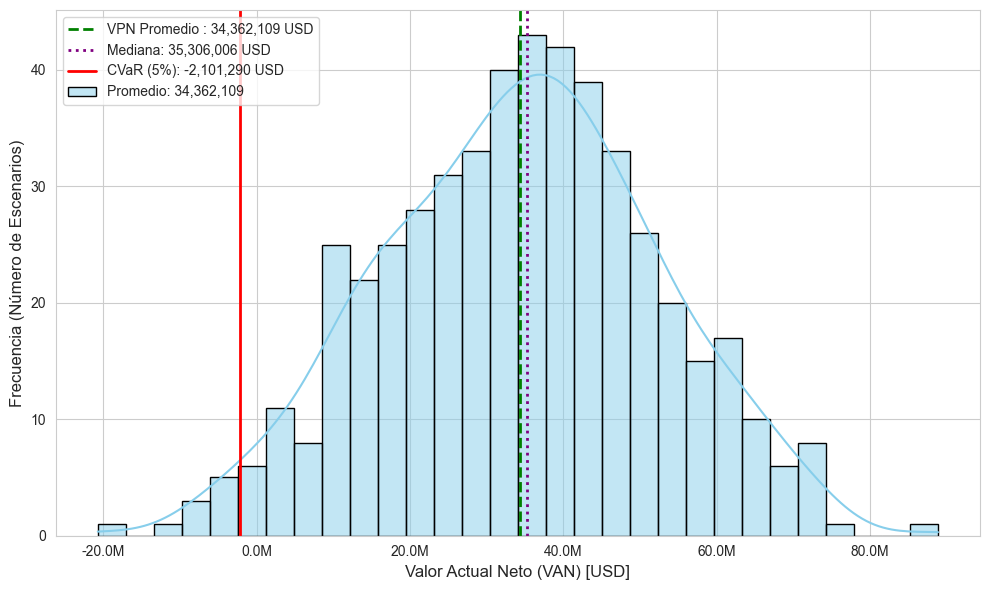

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter

# --- 1. DEFINICIÓN DE LA COMBINACIÓN ---
NPV_SELECCIONADO = 10
NSTS_SELECCIONADO = 124
# ----------------------------------------

# >>> CAMBIO 1: Usar df_final, que contiene los resultados del PPA <<<
# NOTA: Asegúrate de que df_final existe y es tu DataFrame con PPA.
df_base = df_final[df_final['Nsts']<630].copy() 

# 2. Identificar las columnas de VAN de Escenarios
# Estas son las columnas que tienen el VAN del PPA sumado
van_escenario_cols = [col for col in df_base.columns if col.startswith('VAN_Esc_')]
# van_escenario_cols = [col for col in df_base.columns if col.startswith('Revenue_Esc_')]

# 3. FILTRAR EL DATAFRAME para la combinación Npv y Nsts seleccionada
df_fila_seleccionada = df_base[
    (df_base['Npv'] == NPV_SELECCIONADO) & 
    (df_base['Nsts'] == NSTS_SELECCIONADO)
]

# 4. Verificar si la combinación existe
if df_fila_seleccionada.empty:
    print(f"❌ Error: No se encontró la combinación Npv={NPV_SELECCIONADO}, Nsts={NSTS_SELECCIONADO} en el DataFrame final.")
else:
    # 5. Extraer los valores VAN de los escenarios como un array/serie
    van_valores_escenarios = df_fila_seleccionada[van_escenario_cols].iloc[0]
    van_data = van_valores_escenarios.values

    # -------------------------------------------------------------
    # 5B. CALCULAR LA MEDIANA A PARTIR DE LOS DATOS
    median_van = np.median(van_data)
    # -------------------------------------------------------------

    # --- 6. PLOTEO DEL HISTOGRAMA ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    sns.histplot(
        van_data, 
        bins=30, 
        kde=True, 
        color="skyblue", 
        edgecolor="black",
        label=f'Promedio: {np.mean(van_data):,.0f}'
    )

    # --- Agregar Líneas de Referencia ---
    
    # 1. Línea del VAN Promedio FINAL (Verde)
    mean_van = df_fila_seleccionada['VAN_PROMEDIO_FINAL'].iloc[0]
    plt.axvline(mean_van, color='green', linestyle='--', linewidth=2, label=f'VPN Promedio : {mean_van:,.0f} USD')

    # 2. Línea de la MEDIANA (Morado)
    plt.axvline(median_van, color='purple', linestyle=':', linewidth=2, label=f'Mediana: {median_van:,.0f} USD')

    # 3. Línea del CVaR FINAL (Rojo)
    if 'VAN_CVAR_FINAL' in df_fila_seleccionada.columns:
        cvar_van = df_fila_seleccionada['VAN_CVAR_FINAL'].iloc[0]
        plt.axvline(cvar_van, color='red', linestyle='-', linewidth=2, label=f'CVaR (5%): {cvar_van:,.0f} USD')

    # --- Formato y Etiquetas ---
    formatter_millions = FuncFormatter(lambda x, pos: f'{x/1e6:,.1f}M')
    
    plt.gca().xaxis.set_major_formatter(formatter_millions)
    # plt.title(
    #     f'Distribución FINAL del VAN (con PPA) para Diseño: Npv={NPV_SELECCIONADO}, Nsts={NSTS_SELECCIONADO}',
    #     fontsize=16
    # )
    plt.xlabel('Valor Actual Neto (VAN) [USD]', fontsize=12)
    plt.ylabel('Frecuencia (Número de Escenarios)', fontsize=12)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig('16_max_van.pdf')
    plt.show()
    

In [ ]:
# import pandas as pd
# import joypy
# import matplotlib.pyplot as plt

# # --- PASO 1: Preparar los datos ---
# # Seleccionamos Npv y las columnas de escenarios
# cols_to_melt = ['Npv'] + [col for col in df_final.columns if col.startswith('VAN_Esc_')]
# df_melt_npv = df_final[cols_to_melt].copy()

# # Transformamos a formato largo ("melt")
# df_long_npv = df_melt_npv.melt(
#     id_vars=['Npv'], 
#     value_vars=[col for col in df_melt_npv.columns if col.startswith('VAN_Esc_')], 
#     var_name='Escenario', 
#     value_name='Valor_VAN'
# )

# # --- PASO CLAVE: Convertir a Millones ---
# # Dividimos por 1,000,000 para escalar el eje X
# df_long_npv['Valor_VAN_MM'] = df_long_npv['Valor_VAN'] / 1_000_000

# # Opcional: Ordenar o redondear Npv si es necesario
# df_long_npv['Npv_Categoria'] = (MWp_perfil*df_long_npv['Npv']).round(0).astype(int)

# # --- PASO 2: Graficar ---
# fig, axes = joypy.joyplot(
#     df_long_npv, 
#     by='Npv_Categoria',          # Eje Y (Categorías)
#     column='Valor_VAN_MM',       # Eje X (Valores ya en millones)
#     kind="kde",
#     xlabels=True,
#     ylabels=True,
#     figsize=(12, 10),            # Un poco más grande para ver mejor
#     overlap=1.5,                 # Superposición estilo "Ridge"
#     linecolor="black",           # Borde negro como tu imagen
#     fill=True,
#     color="#1f77b4",             # Azul clásico
#     linewidth=1,
#     alpha=0.8                    # Un poco de transparencia
# )

# # Ajustar etiquetas
# plt.xlabel("VAN (Millones de USD)", fontsize=12, fontweight='bold')
# plt.ylabel("Npv", fontsize=12, fontweight='bold')
# plt.suptitle("Distribución VAN por Npv (MM USD)", fontsize=16, y=1.02)

# plt.show()

In [ ]:
# # --- PASO 1: Preparar datos para Nsts ---
# cols_to_melt = ['Nsts'] + [col for col in df_final.columns if col.startswith('VAN_Esc_')]
# df_melt_nsts = df_final[cols_to_melt].copy()

# df_long_nsts = df_melt_nsts.melt(
#     id_vars=['Nsts'], 
#     value_vars=[col for col in df_melt_nsts.columns if col.startswith('VAN_Esc_')], 
#     var_name='Escenario', 
#     value_name='Valor_VAN'
# )

# # --- PASO CLAVE: Convertir a Millones ---
# df_long_nsts['Valor_VAN_MM'] = df_long_nsts['Valor_VAN'] / 1_000_000
# df_long_nsts['Nsts_Categoria'] = (cbat_valor*Nbat_valor*df_long_nsts['Nsts']).round(0).astype(int)

# # --- PASO 2: Graficar ---
# fig, axes = joypy.joyplot(
#     df_long_nsts, 
#     by='Nsts_Categoria',
#     column='Valor_VAN_MM',       # Usamos la columna en millones
#     kind="kde",
#     xlabels=True,
#     ylabels=True,
#     figsize=(12, 10),
#     overlap=1.5,
#     linecolor="black",
#     fill=True,
#     color="#1f77b4",
#     linewidth=1,
#     alpha=0.8
# )

# plt.xlabel("VAN (Millones de USD)", fontsize=12, fontweight='bold')
# plt.ylabel("Nsts", fontsize=12, fontweight='bold')
# plt.suptitle("Distribución VAN por Nsts (MM USD)", fontsize=16, y=1.02)

# plt.show()

In [ ]:
import pandas as pd
import numpy as np

def calcular_flujos_energia(
    df_datos_alineados: pd.DataFrame,
    Nsts: int,
    Nbat: int,
    cbat: float,
    Npv: int,
    D0: float,
    eta_poi: float
) -> pd.DataFrame:
    """
    Calcula los flujos de energía (PV, BESS, POI) basándose en perfiles normalizados y parámetros técnicos.
    Elimina columnas que comiencen con 'Lagunas' o 'AltoJahuel'.
    
    Retorna:
        pd.DataFrame: Copia del dataframe original limpio y con los flujos calculados.
    """
    
    # 1. Crear copia para no modificar el original y configurar índice
    df = df_datos_alineados.copy()
    if 'Fecha_Hora' in df.columns:
        df = df.set_index('Fecha_Hora')

    # --- 1.5 LIMPIEZA DE COLUMNAS ---
    # Identificar columnas que empiezan con 'Lagunas' o 'AltoJahuel'
    cols_to_drop = [col for col in df.columns if col.startswith(('Lagunas', 'AltoJahuel'))]
    
    # Eliminarlas si existen
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)
    # -------------------------------
    
    # 2. Definición de nombres de columnas (Hardcoded según tu estructura)
    col_pv = 'perfil_pv_interno'
    col_carga = 'perfil_carga'      # Carga BESS (Consumo)
    col_descarga = 'perfil_descarga' # Descarga BESS (Inyección)
    col_soh = 'SOH'
    col_rte = 'RTE'
    col_cliente = 'Retiro'

    # 3. Validación básica: asegurar que las columnas NECESARIAS existan
    required_cols = [col_pv, col_carga, col_descarga, col_soh, col_rte]
    if not all(col in df.columns for col in required_cols):
        missing = [c for c in required_cols if c not in df.columns]
        raise ValueError(f"Faltan las siguientes columnas en el DataFrame: {missing}")

    # 4. Cálculo de Factores
    # Factor de capacidad total del BESS
    factor_bess = Nsts * Nbat * cbat 
    
    # Factores dinámicos de eficiencia y degradación
    # sqrt se aplica a toda la columna vectorizadamente
    sqrt_rte = np.sqrt(df[col_rte])
    factor_descarga_bateria = (D0 * df[col_soh] * sqrt_rte * eta_poi)
    factor_carga_bateria = (D0 * df[col_soh] / (sqrt_rte * eta_poi))

    # 5. Cálculo de Flujos de Potencia (MW)
    df['Iny_PV'] = df[col_pv] * Npv * eta_poi
    df['des_BESS'] = df[col_descarga] * factor_bess * factor_descarga_bateria
    df['car_BESS'] = df[col_carga] * factor_bess * factor_carga_bateria
    
    df['Retiro'] = df[col_cliente]
    # 6. POI Total
    df['POI'] = df['Iny_PV'] + df['des_BESS'] - df['car_BESS']
    
    return df

In [ ]:
# Suponiendo que ya tienes df_alineado cargado
Npv_i    = 32
Nsts_i   = 98

df_flujo = calcular_flujos_energia(
        df_datos_alineados=df_alineado,
        Nsts=Nsts_i,
        Nbat=Nbat_valor, 
        cbat=cbat_valor,
        Npv=Npv_i,
        D0= Do,
        eta_poi= eta_poi
)

# Ver los resultados
print(df_flujo[['Iny_PV', 'des_BESS', 'car_BESS', 'POI']].head(15))
# df_flujo.to_excel('Flujos.xlsx',index=True)

                         Iny_PV  des_BESS    car_BESS         POI
Fecha_Hora                                                       
2029-04-01 00:00:00    0.000000       0.0    0.000000    0.000000
2029-04-01 01:00:00    0.000000       0.0    0.000000    0.000000
2029-04-01 02:00:00    0.000000       0.0    0.000000    0.000000
2029-04-01 03:00:00    0.000000       0.0    0.000000    0.000000
2029-04-01 04:00:00    0.000000       0.0    0.000000    0.000000
2029-04-01 05:00:00    0.000000       0.0    0.000000    0.000000
2029-04-01 06:00:00    0.000000       0.0    0.000000    0.000000
2029-04-01 07:00:00   46.819808       0.0    0.000000   46.819808
2029-04-01 08:00:00  133.890656       0.0  344.040216 -210.149560
2029-04-01 09:00:00  207.398448       0.0  344.040216 -136.641768
2029-04-01 10:00:00  258.839088       0.0  344.040216  -85.201128
2029-04-01 11:00:00  293.123392       0.0  344.040216  -50.916824
2029-04-01 12:00:00  306.790464       0.0  344.040216  -37.249752
2029-04-01

Muestra de datos procesados:
Bloque_Temp           A          B           C  Bloque A+C   Bloque B
Año                                                                  
2029         270.959006 -11.289345  216.658649  487.617655 -11.289345
2030         364.615430   6.274402  269.301590  633.917020   6.274402
2031         337.834249  18.732608  280.747836  618.582084  18.732608
2032         343.281766  28.858063  265.408185  608.689951  28.858063
2033         355.249208  37.514510  240.949734  596.198942  37.514510
📈 Generando gráfico divergente...


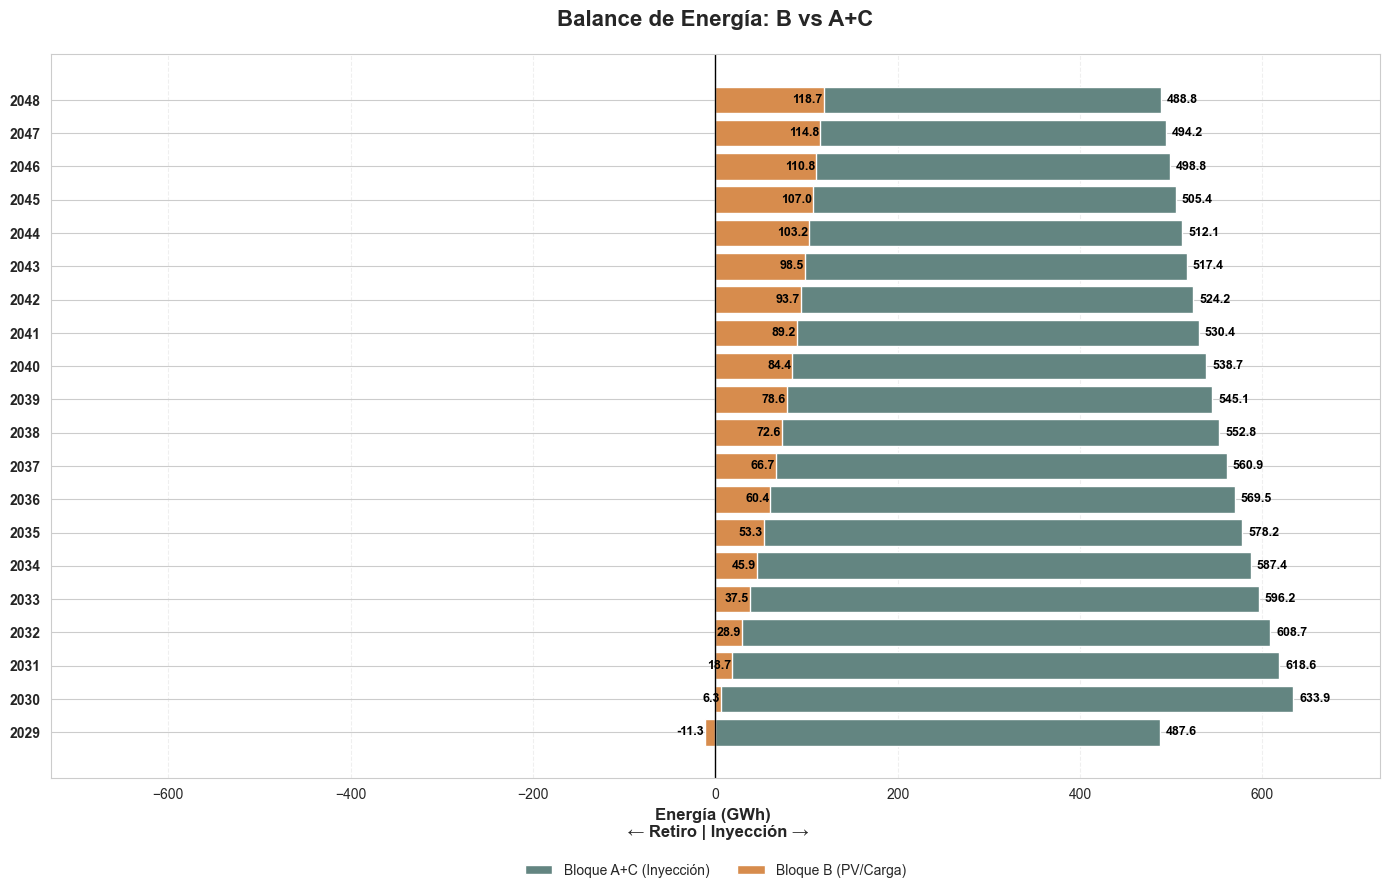

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def preparar_datos_bloques_agrupados(df_input, col_fecha='Fecha_Hora', col_potencia='POI'):
    """
    Procesa los datos para obtener Bloque B y Bloque A+C.
    """
    df = df_input.copy()
    
    # 1. Configuración de fecha
    if col_fecha in df.columns:
        df[col_fecha] = pd.to_datetime(df[col_fecha])
        df['Año'] = df[col_fecha].dt.year
        df['Hora'] = df[col_fecha].dt.hour
    else:
        df = df.reset_index()
        if 'Fecha_Hora' not in df.columns:
            df.rename(columns={df.columns[0]: 'Fecha_Hora'}, inplace=True)
        df['Año'] = df['Fecha_Hora'].dt.year
        df['Hora'] = df['Fecha_Hora'].dt.hour

    # 2. Asignar Bloques
    conditions = [
        df['Hora'].isin([23, 0, 1, 2, 3, 4, 5, 6, 7]),           # A
        df['Hora'].isin([8, 9, 10, 11, 12, 13, 14, 15, 16, 17]), # B
        df['Hora'].isin([18, 19, 20, 21, 22])                    # C
    ]
    choices = ['A', 'B', 'C']
    df['Bloque_Temp'] = np.select(conditions, choices, default='Otro')

    # 3. Agrupar y sumar
    annual_blocks = df.groupby(['Año', 'Bloque_Temp'])[col_potencia].sum().reset_index()
    annual_blocks['Energia_GWh'] = annual_blocks[col_potencia] / 1000

    # 4. Pivotar y Rellenar
    pivot_data = annual_blocks.pivot(index='Año', columns='Bloque_Temp', values='Energia_GWh').fillna(0)
    
    for b in ['A', 'B', 'C']:
        if b not in pivot_data.columns:
            pivot_data[b] = 0.0

    # 5. Fusión y Ajuste de Signo
    pivot_data['Bloque A+C'] = pivot_data['A'] + pivot_data['C']
    pivot_data['Bloque B'] = pivot_data['B']
    
    # --- CORRECCIÓN IMPORTANTE ---
    # Si Bloque B es consumo/retiro, debe ser negativo. 
    # Si tus datos vienen positivos pero quieres graficarlos a la izquierda, descomenta esta línea:
    # if pivot_data['Bloque B'].sum() > 0:
    #     pivot_data['Bloque B'] = pivot_data['Bloque B'] * -1
        
    # pivot_data = pivot_data[['Bloque A+C', 'Bloque B']].sort_index(ascending=True) 

    return pivot_data

def graficar_inyeccion_divergente(pivot_data):
    """
    Grafica Bloque A+C (derecha/positivo) y Bloque B (izquierda/negativo)
    compartiendo el eje cero central.
    """
    if pivot_data is None or pivot_data.empty:
        print("❌ No hay datos para graficar.")
        return

    print(f"📈 Generando gráfico divergente...")
    
    fig, ax = plt.subplots(figsize=(14, 9))
    
    years = pivot_data.index
    y_pos = np.arange(len(years))
    
    # --- BLOQUE A+C (Positivo / Derecha) ---
    val_ac = pivot_data['Bloque A+C'].values
    ax.barh(y_pos, val_ac, align='center', color="#638581", label='Bloque A+C (Inyección)', edgecolor='white')

    # --- BLOQUE B (Negativo / Izquierda) ---
    val_b = pivot_data['Bloque B'].values
    ax.barh(y_pos, val_b, align='center', color="#D78C4D", label='Bloque B (PV/Carga)', edgecolor='white')

    # --- ETIQUETAS DE VALORES ---
    # Etiquetas para positivos (A+C)
    for i, v in enumerate(val_ac):
        if abs(v) > 1:
            ax.text(v + (max(val_ac)*0.01), i, f'{v:.1f}', ha='left', va='center', color='black', fontweight='bold', fontsize=9)

    # Etiquetas para negativos (B)
    for i, v in enumerate(val_b):
        if abs(v) > 1:
            # v es negativo, restamos un poco para mover el texto a la izquierda de la barra
            ax.text(v - (max(abs(val_b))*0.01), i, f'{v:.1f}', ha='right', va='center', color='black', fontweight='bold', fontsize=9)

    # --- ESTÉTICA ---
    # Línea vertical en el cero
    ax.axvline(0, color='black', linewidth=1, linestyle='-')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(years, fontweight='bold')
    ax.set_title('Balance de Energía: B vs A+C', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Energía (GWh) \n ← Retiro | Inyección →', fontsize=12, fontweight='bold')
    
    # Ajustar límites del eje X para que quede simétrico o balanceado
    max_val = max(pivot_data['Bloque A+C'].max(), abs(pivot_data['Bloque B'].min())) * 1.15
    ax.set_xlim(-max_val, max_val)
    
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, frameon=False)
    
    plt.tight_layout()
    plt.savefig(f'Flujo_T_{Nsts_i}_{Npv_i}.pdf')
    plt.show()

# --- EJECUCIÓN ---
df_grafico = preparar_datos_bloques_agrupados(df_flujo, col_potencia='POI')

# VERIFICACIÓN:
# Si al imprimir esto, el Bloque B es positivo, el gráfico NO saldrá a la izquierda.
# Si es positivo, activa la línea de corrección dentro de la función preparar_datos_bloques_agrupados
print("Muestra de datos procesados:")
print(df_grafico.head())

graficar_inyeccion_divergente(df_grafico)

📈 Generando gráfico (B vs A+C)...


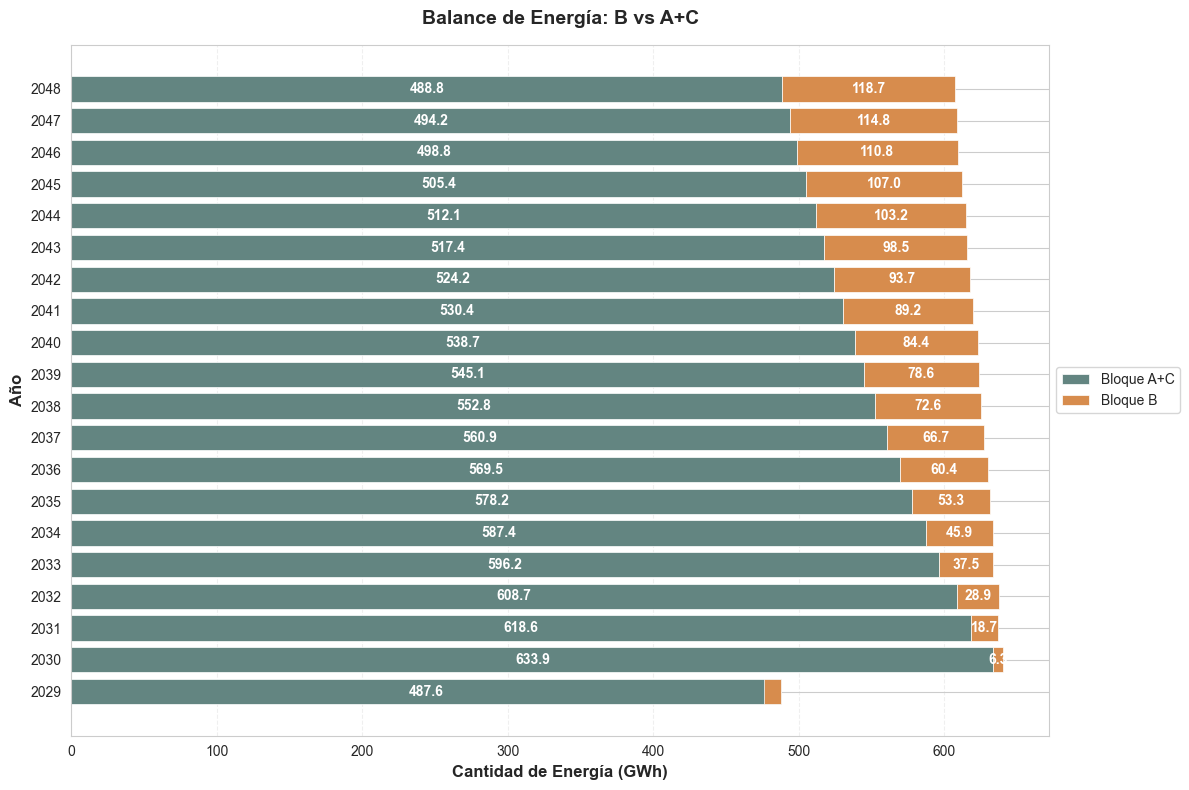

Bloque_Temp  Bloque A+C    Bloque B
Año                                
2029         487.617655  -11.289345
2030         633.917020    6.274402
2031         618.582084   18.732608
2032         608.689951   28.858063
2033         596.198942   37.514510
2034         587.440579   45.944549
2035         578.181113   53.284592
2036         569.518449   60.441056
2037         560.927115   66.745583
2038         552.771684   72.645017
2039         545.103136   78.569724
2040         538.699138   84.384404
2041         530.444038   89.163723
2042         524.168036   93.738540
2043         517.390488   98.514758
2044         512.083262  103.206703
2045         505.362840  107.047684
2046         498.752167  110.839400
2047         494.238759  114.776148
2048         488.837791  118.731167


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def preparar_datos_bloques_agrupados(df_input, col_fecha='Fecha_Hora', col_potencia='POI'):
    """
    Procesa los datos para obtener Bloque B y Bloque A+C (suma).
    """
    df = df_input.copy()
    
    # 1. Asegurar formato fecha
    if col_fecha in df.columns:
        df[col_fecha] = pd.to_datetime(df[col_fecha])
        df['Año'] = df[col_fecha].dt.year
        df['Hora'] = df[col_fecha].dt.hour
    else:
        df = df.reset_index()
        if 'Fecha_Hora' not in df.columns:
            df.rename(columns={df.columns[0]: 'Fecha_Hora'}, inplace=True)
        df['Año'] = df['Fecha_Hora'].dt.year
        df['Hora'] = df['Fecha_Hora'].dt.hour

    # 2. Asignar Bloques A, B, C preliminarmente
    conditions = [
        df['Hora'].isin([23, 0, 1, 2, 3, 4, 5, 6, 7]),          # A
        df['Hora'].isin([8, 9, 10, 11, 12, 13, 14, 15, 16, 17]), # B
        df['Hora'].isin([18, 19, 20, 21, 22])                    # C
    ]
    choices = ['A', 'B', 'C']
    df['Bloque_Temp'] = np.select(conditions, choices, default='Otro')

    # 3. Agrupar y sumar
    annual_blocks = df.groupby(['Año', 'Bloque_Temp'])[col_potencia].sum().reset_index()
    annual_blocks['Energia_GWh'] = annual_blocks[col_potencia] / 1000

    # 4. Pivotar
    pivot_data = annual_blocks.pivot(index='Año', columns='Bloque_Temp', values='Energia_GWh').fillna(0)
    
    # Asegurar columnas
    for b in ['A', 'B', 'C']:
        if b not in pivot_data.columns:
            pivot_data[b] = 0.0

    # --- 5. FUSIÓN DE BLOQUES (A+C) ---
    pivot_data['Bloque A+C'] = pivot_data['A'] + pivot_data['C']
    pivot_data['Bloque B'] = pivot_data['B']
    
    # Seleccionar solo las columnas finales
    pivot_data = pivot_data[['Bloque A+C', 'Bloque B']]
    
    # Ordenar años (índice)
    pivot_data = pivot_data.sort_index(ascending=True) 

    return pivot_data

def graficar_inyeccion_agrupada(pivot_data):
    """
    Grafica solo Bloque A+C y Bloque B.
    """
    if pivot_data is None or pivot_data.empty:
        print("❌ No hay datos para graficar.")
        return

    print(f"📈 Generando gráfico (B vs A+C)...")
    
    # Colores: 
    # B (Solar): Gris/Verdoso
    # A+C (Resto): Naranja/Tierra (Usamos el color del antiguo C para resaltar)
    colors = {
        "Bloque A+C": "#638581",  # Naranja (Noche + Punta)
        "Bloque B": "#D78C4D"     # Verde Grisáceo (Solar)
    }
    
    # Orden de apilado: ¿Qué quieres abajo?
    # Usualmente Solar (B) abajo y Resto (A+C) arriba, o viceversa.
    # Aquí pondremos A+C abajo y B arriba.
    columnas_a_graficar = ['Bloque A+C', 'Bloque B'] 

    fig, ax = plt.subplots(figsize=(12, 8))
    
    years = pivot_data.index
    y_pos = np.arange(len(years))
    bottom = np.zeros(len(years))
    
    for col_name in columnas_a_graficar:
        values = pivot_data[col_name].values
        ax.barh(y_pos, values, left=bottom, 
                color=colors[col_name], label=col_name,
                height=0.8, edgecolor='white', linewidth=0.5)
        
        # Etiquetas
        for i, val in enumerate(values):
            if val > 1.0: 
                x_pos = bottom[i] + val / 2
                ax.text(x_pos, y_pos[i], f'{val:.1f}', 
                        ha='center', va='center', 
                        color='white', fontweight='bold', fontsize=10)
        
        bottom += values

    # Estilos
    ax.set_xlabel('Cantidad de Energía (GWh)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Año', fontsize=12, fontweight='bold')
    ax.set_title('Balance de Energía: B vs A+C', 
                 fontsize=14, fontweight='bold', pad=15)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(years)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.savefig(f'Flujo_{Nsts_i}_{Npv_i}.pdf')
    plt.show()

# --- EJECUCIÓN ---

# 1. Procesar datos (df_resultados viene de tu función anterior calcular_flujos_energia)
df_grafico_ac_b = preparar_datos_bloques_agrupados(df_flujo, col_potencia='POI')

# 2. Graficar
graficar_inyeccion_agrupada(df_grafico_ac_b)

# 3. Ver tabla
print(df_grafico_ac_b)

📈 Generando gráfico de perfil horario promedio para el año 2036...
✅ Gráfico guardado como: Perfil_Horario_Año2036_98_32.pdf


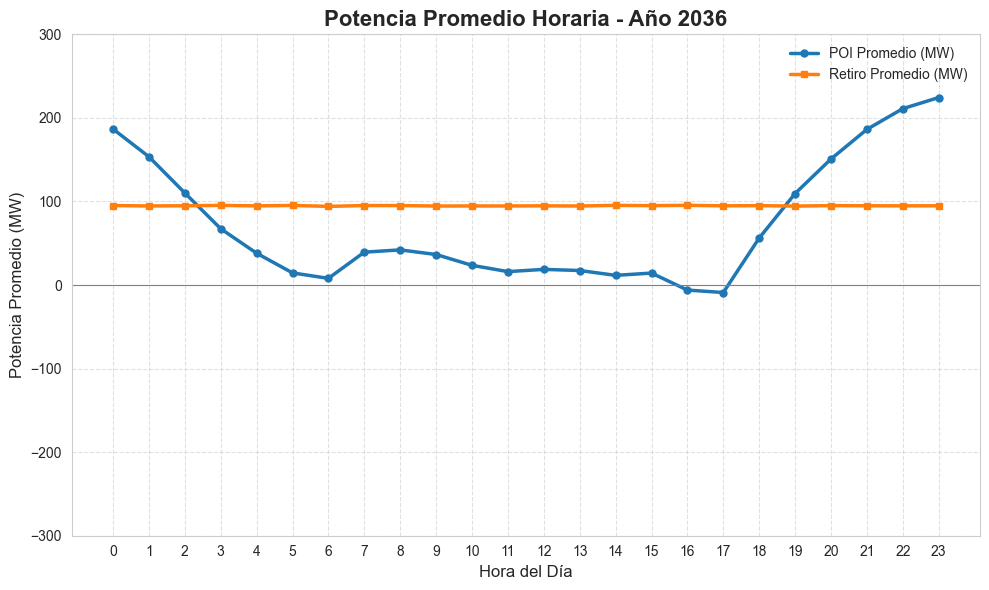

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def calcular_promedio_horario(df_flujo: pd.DataFrame, target_year: int) -> pd.DataFrame:
    """
    Calcula la potencia promedio por hora del día para POI y Retiro,
    filtrando por un año específico.
    """
    df = df_flujo.copy()

    # 1. Asegurar la columna de Año y Hora
    # Asume que el índice es 'Fecha_Hora' (datetime) o existe como columna
    if not isinstance(df.index, pd.DatetimeIndex):
        # Si 'Fecha_Hora' no es el índice, asume que está como columna
        if 'Fecha_Hora' in df.columns:
            df = df.set_index('Fecha_Hora')
        elif 'Año' not in df.columns or 'Hora' not in df.columns:
             # Si no tiene índice Datetime ni columnas de Año/Hora, no se puede procesar
            raise ValueError("El DataFrame debe tener un índice de tipo Datetime o las columnas 'Fecha_Hora', 'Año' y 'Hora'.")
    
    # Extraer Año y Hora si no existen como columnas (útil si el índice es datetime)
    if 'Año' not in df.columns:
        df['Año'] = df.index.year
    if 'Hora' not in df.columns:
        df['Hora'] = df.index.hour

    # 2. Filtrar por el año objetivo
    df_filtered = df[df['Año'] == target_year]
    
    if df_filtered.empty:
        print(f"❌ Advertencia: No se encontraron datos para el año {target_year}.")
        return None

    # 3. Calcular la potencia promedio para cada hora del día
    hourly_avg = df_filtered.groupby('Hora')[['POI', 'Retiro']].mean().reset_index()
    
    # Renombrar para claridad en el gráfico
    hourly_avg.rename(columns={'POI': 'POI Promedio (MW)', 'Retiro': 'Retiro Promedio (MW)'}, inplace=True)
    
    return hourly_avg
def graficar_promedio_horario(df_hourly_avg: pd.DataFrame, target_year: int, filename_prefix: str = 'Perfil_Horario'):
    """
    Genera un gráfico de líneas para la potencia promedio del POI y Retiro vs. Hora.
    """
    if df_hourly_avg is None or df_hourly_avg.empty:
        return

    print(f"📈 Generando gráfico de perfil horario promedio para el año {target_year}...")

    fig, ax = plt.subplots(figsize=(10, 6))

    # --- Trazado de las líneas ---
    
    # POI Promedio
    ax.plot(df_hourly_avg['Hora'], df_hourly_avg['POI Promedio (MW)'], 
            label='POI Promedio (MW)', 
            color='#1f77b4', linewidth=2.5, marker='o', markersize=5)
    
    # Retiro Promedio (Cliente)
    ax.plot(df_hourly_avg['Hora'], df_hourly_avg['Retiro Promedio (MW)'], 
            label='Retiro Promedio (MW)', 
            color='#ff7f0e', linewidth=2.5, marker='s', markersize=5)

    # --- Estética y Etiquetas ---
    ax.set_ylim(-300, 300)
    ax.set_title(f'Potencia Promedio Horaria - Año {target_year}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Hora del Día', fontsize=12)
    ax.set_ylabel('Potencia Promedio (MW)', fontsize=12)
    
    # Asegurar que el eje X muestre todas las horas de 0 a 23
    ax.set_xticks(range(0, 24)) # Marcas cada 2 horas
    ax.grid(axis='both', linestyle='--', alpha=0.6)
    
    ax.legend(loc='best', frameon=False)
    
    # Línea horizontal en 0 para referencia
    ax.axhline(0, color='gray', linewidth=0.8, linestyle='-')
    
    # Guardar gráfico en función de la variable
    filename = f'{filename_prefix}_Año{target_year}_{Nsts_i}_{Npv_i}.pdf'
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    print(f"✅ Gráfico guardado como: {filename}")
    plt.show()
# Suponiendo que estas variables y df_alineado ya están definidas:
# Npv_i, Nsts_i, Nbat_valor, cbat_valor, Do, eta_poi
# df_flujo = calcular_flujos_energia(...)

# --- CONFIGURACIÓN DE LA EJECUCIÓN ---
target_year_to_plot = 2036 # <-- Define el año que quieres graficar

# 1. Preparar los datos promediados
df_horario_promedio = calcular_promedio_horario(df_flujo, target_year_to_plot)

# 2. Generar el gráfico
if df_horario_promedio is not None:
    graficar_promedio_horario(df_horario_promedio, target_year_to_plot)